In [79]:

import sys, os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patheffects as pe
import itertools
from tqdm.notebook import tqdm
import matplotlib
from IPython import display 

sys.path.append(r"/Users/gerwinkoolstra/Documents/Code")
sys.path.append(r"/Volumes/EeroQ/lib")

from quantum_electron.electron_counter import FullModel, make_potential, find_minimum_location
from quantum_electron.schrodinger_solver import QuantumAnalysis

module_path = r"/Volumes/EeroQ/Projects/004_Device2.0/fem/calc_niyaz"

if module_path not in sys.path:
    print(module_path)
    sys.path.append(module_path)

from pathfinder import init_zhk
zhk_dir=init_zhk()

from zeroheliumkit.old.version0p1.geometries import GeometryCollection
from zeroheliumkit.old.version0p1.settings import *
from zeroheliumkit.eeroq import QubitAnalyzer
from quantum_electron.utils import xy2r, r2xy, crop_potential, find_nearest
import scipy

%matplotlib inline
%config InlineBackend.figure_format='retina'

/Users/gerwinkoolstra/lib


# Load data

In [59]:
save_dir = r"/Volumes/EeroQ/Projects/004_Device2.0/fem/calc_niyaz/trap_2.3.2/work_files/"
device = GeometryCollection(import_file=save_dir + "trap_fem.pickle")
trap = QubitAnalyzer((save_dir+"phi_xy.txt", 'all', '2Dmap'),
                     (save_dir+"phi_xy.txt", 'dot', '2Dmap'),
                    #  (save_dir+"trap_potentialxyZ.txt", 'xyZ', '2Dslices'),
                    #  (save_dir+"trap_perpfieldxy.txt", 'Ez', '2Dmap'),
                     )

print(trap.dot.keys())

/Volumes/EeroQ/Projects/004_Device2.0/fem/calc_niyaz/trap_2.3.2/work_files/trap_fem.pickle: ['bottom', 'dielectric', 'etch', 'top', 'wafer']
dict_keys(['barrier', 'gnd', 'resD', 'resU', 'trench', 'unload', 'xlist', 'ylist'])


In [60]:
electrode_names = list(trap.dot.keys())
electrode_names.remove('xlist')
electrode_names.remove('ylist')

# print(trap.dot['barrier'].shape)
# print(trap.dot['xlist'].shape)

for electrode_name in electrode_names:
    cropped_x, cropped_y, cropped_phi = crop_potential(trap.dot['xlist'], trap.dot['ylist'], trap.dot[electrode_name], 
                                                       xrange=(-1, 1), yrange=(-1.1, 1.1))
    # print(cropped_phi.shape)
    trap.dot[electrode_name] = cropped_phi
    
trap.dot['xlist'] = cropped_x
trap.dot['ylist'] = cropped_y

# print(cropped_x.shape, cropped_y.shape)

# Sweep electron number

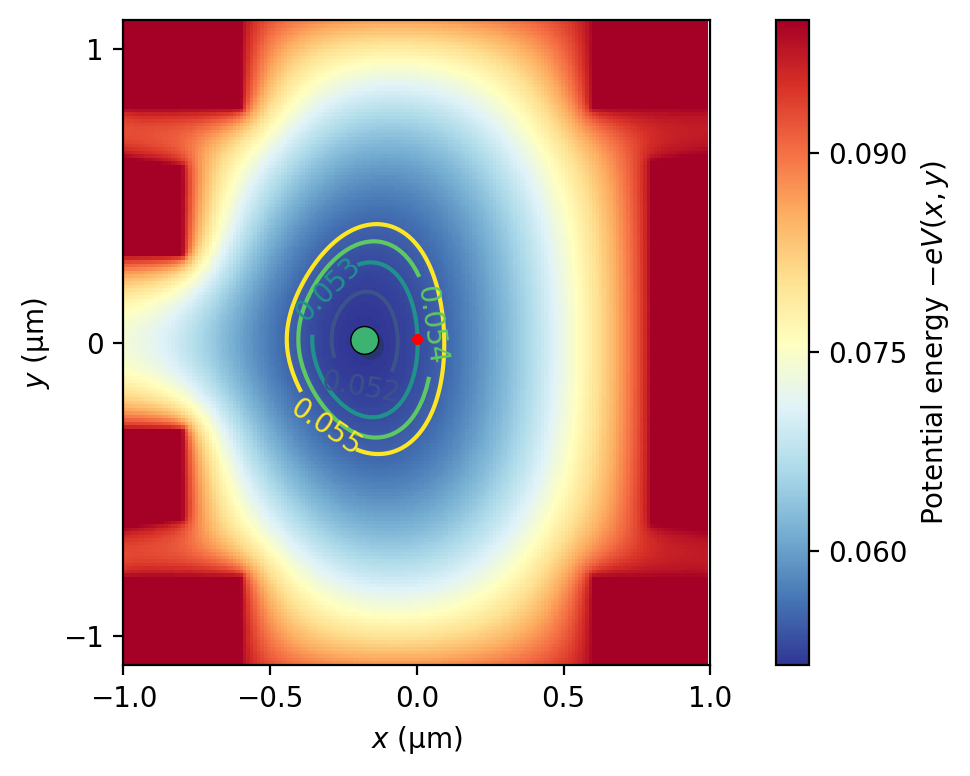

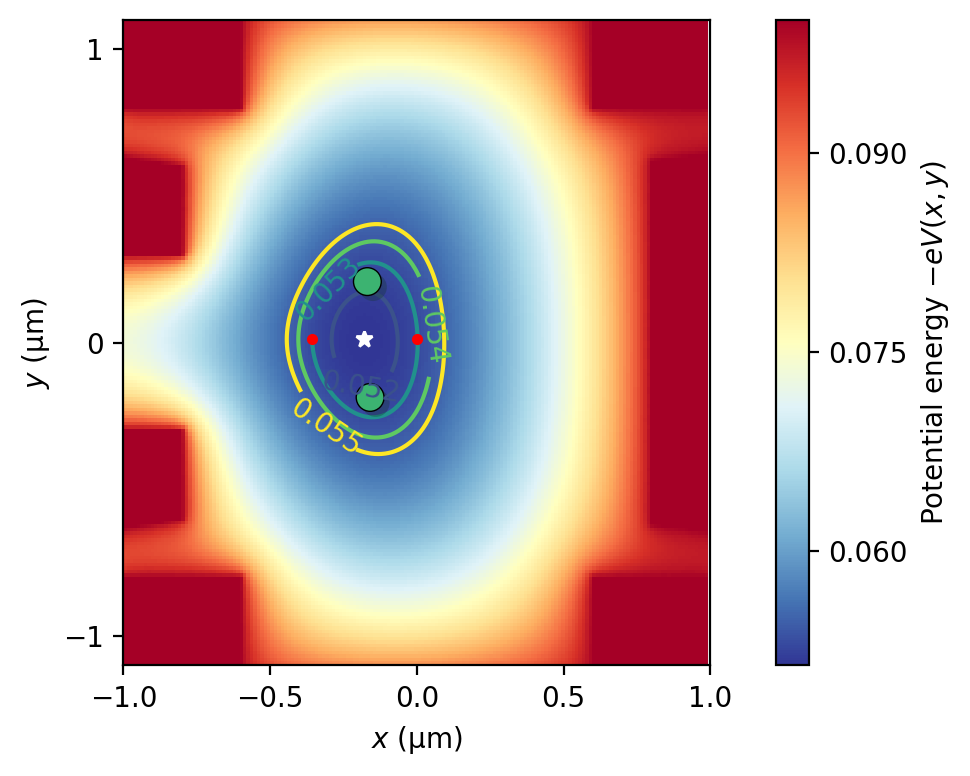

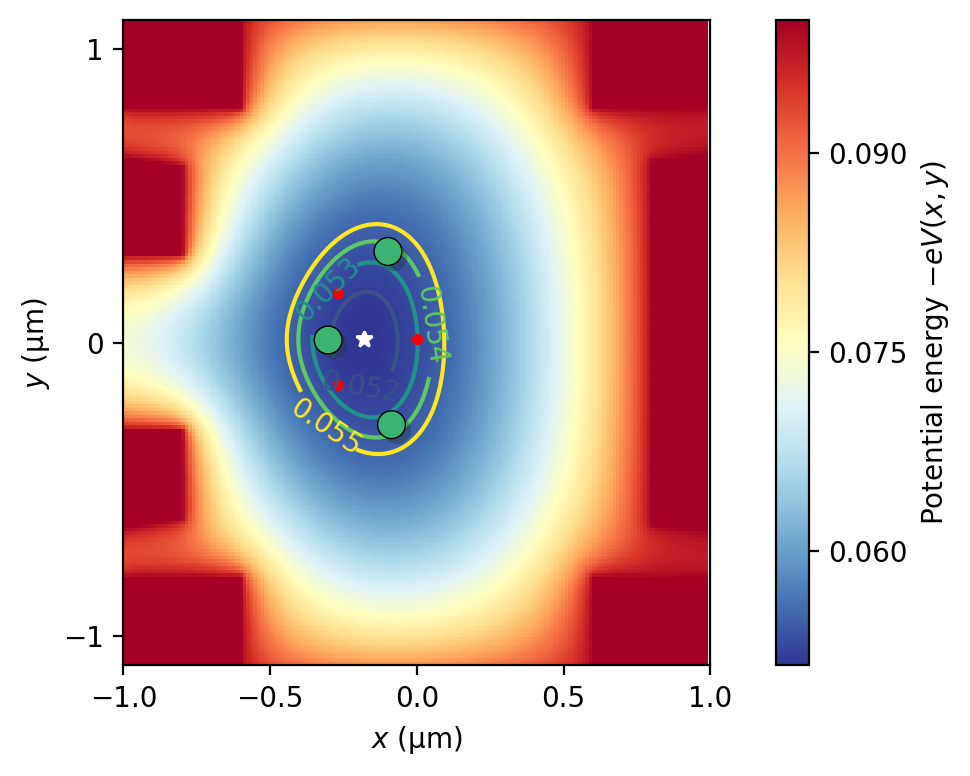

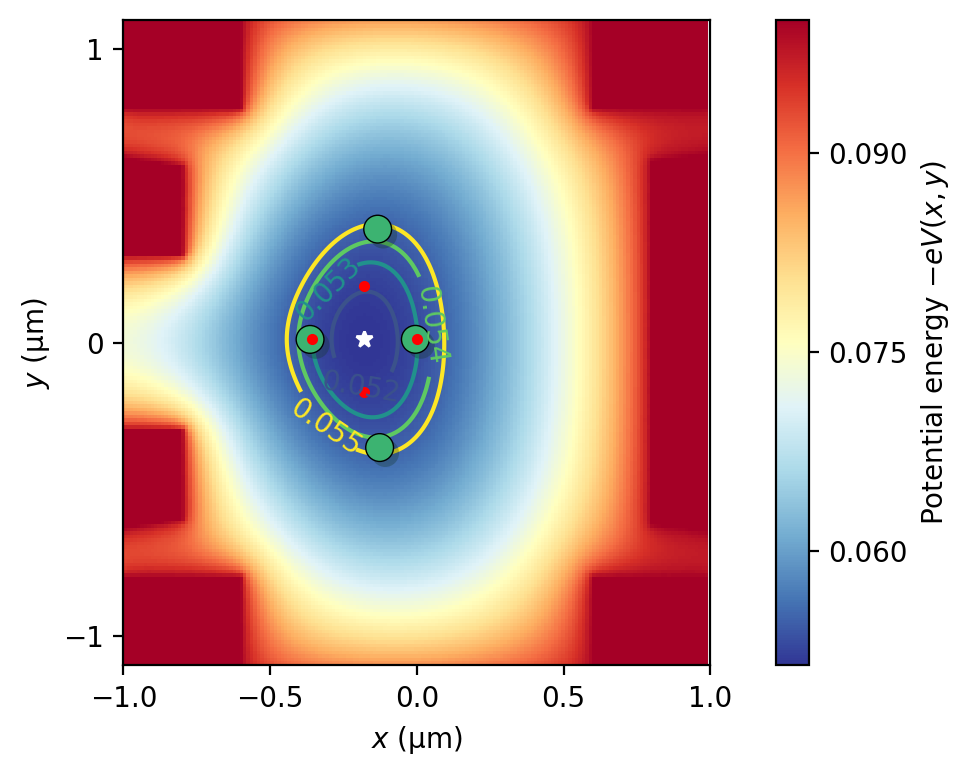

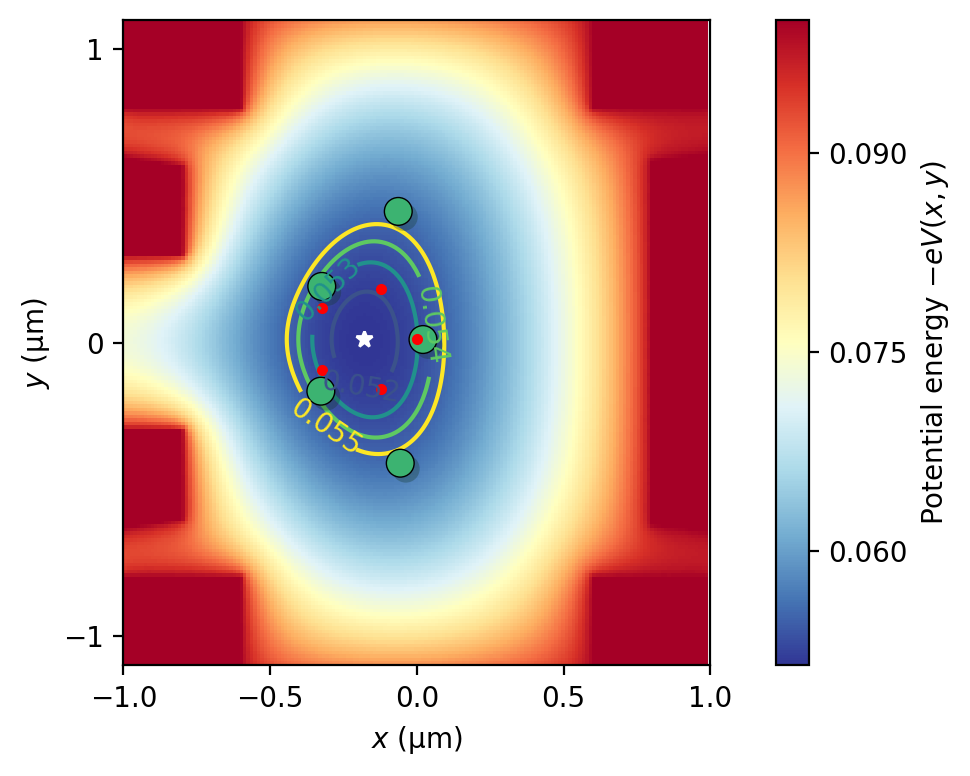

In [4]:
voltages = {'trench':   0.05,
            'gnd':      0, 
            'barrier':  -0.10,
            'resU':     -0.10,
            'resD':     -0.10,
            'unload':   -0.10}

Nmax = 6
energies = np.zeros(Nmax-1)
for N in range(1, Nmax):
    f = FullModel(trap.dot, voltages)
    f.remove_unbound_electrons = False
    
    initial_condition = f.generate_initial_condition(N)
    init_x, init_y = r2xy(initial_condition)
        
    res = f.get_trap_electron_positions(n_electrons=N, electron_initial_positions=None, verbose=False)
    
    final_x, final_y = r2xy(res['x'])
    
    qa = QuantumAnalysis(trap.dot, voltages)
    qa.plot_potential_energy(coor=[0, 0], dxdy=(2, 2.2))
    plt.plot(final_x*1e6, final_y*1e6, 'ok', mfc='mediumseagreen', mew=0.5, ms=10, path_effects=[pe.SimplePatchShadow(), pe.Normal()])
    plt.plot(init_x*1e6, init_y*1e6, 'or', ms=3)

    energies[N-1] = res['fun']

Text(0, 0.5, 'Cost function')

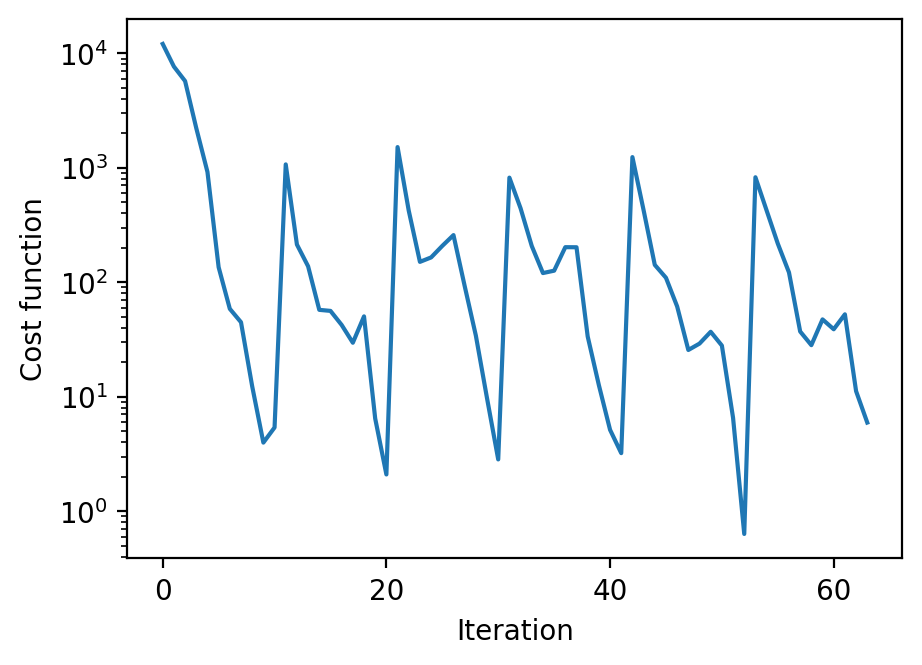

In [5]:
fig = plt.figure(figsize=(5.,3.5))
plt.plot(f.CM.curr_grad_norm)
plt.yscale('log')
plt.locator_params(axis='x', nbins=4)
plt.xlabel("Iteration")
plt.ylabel("Cost function")

# Sweep unload voltage

Final L-inf norm of gradient = 7788.61 eV/m
Please check your initial condition, are all electrons confined in the simulation area?
Following electrons are outside the simulation domain
(x,y) = (-8.315, -0.022) um
Final L-inf norm of gradient = 2415.97 eV/m
Please check your initial condition, are all electrons confined in the simulation area?


/var/folders/x8/8j91v5z97qvb60vlfp731zth0000gn/T/ipykernel_92575/2827154336.py:45: RuntimeWarning: invalid value encountered in sqrt
  eigenfrequencies = np.sqrt(evals) / (2 * np.pi)
/Users/gerwinkoolstra/Documents/Code/quantum_electron/schrodinger_solver.py:535: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


Following electrons are outside the simulation domain
(x,y) = (-8.446, 0.023) um
Final L-inf norm of gradient = 3901.89 eV/m
Please check your initial condition, are all electrons confined in the simulation area?
Following electrons are outside the simulation domain
(x,y) = (-8.486, 0.007) um
Final L-inf norm of gradient = 4087.28 eV/m
Please check your initial condition, are all electrons confined in the simulation area?
Following electrons are outside the simulation domain
(x,y) = (-8.574, -0.008) um
Final L-inf norm of gradient = 5476.91 eV/m
Please check your initial condition, are all electrons confined in the simulation area?
Following electrons are outside the simulation domain
(x,y) = (-8.612, 0.021) um
Final L-inf norm of gradient = 5231.63 eV/m
Please check your initial condition, are all electrons confined in the simulation area?
Following electrons are outside the simulation domain
(x,y) = (-8.694, -0.021) um
Final L-inf norm of gradient = 5897.04 eV/m
Please check your ini

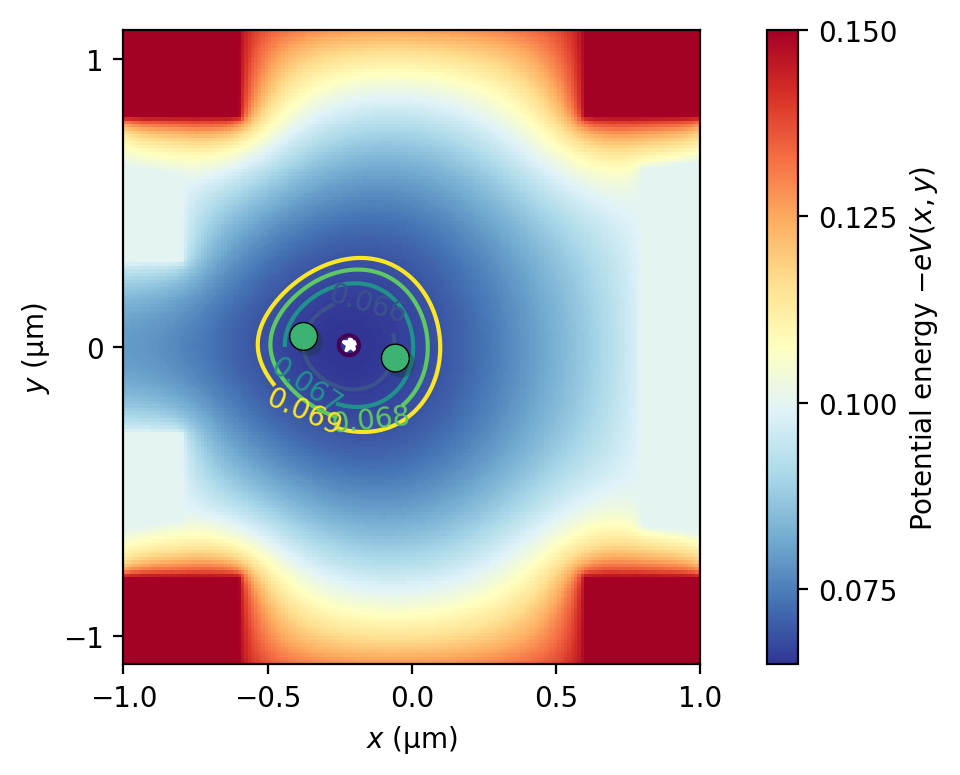

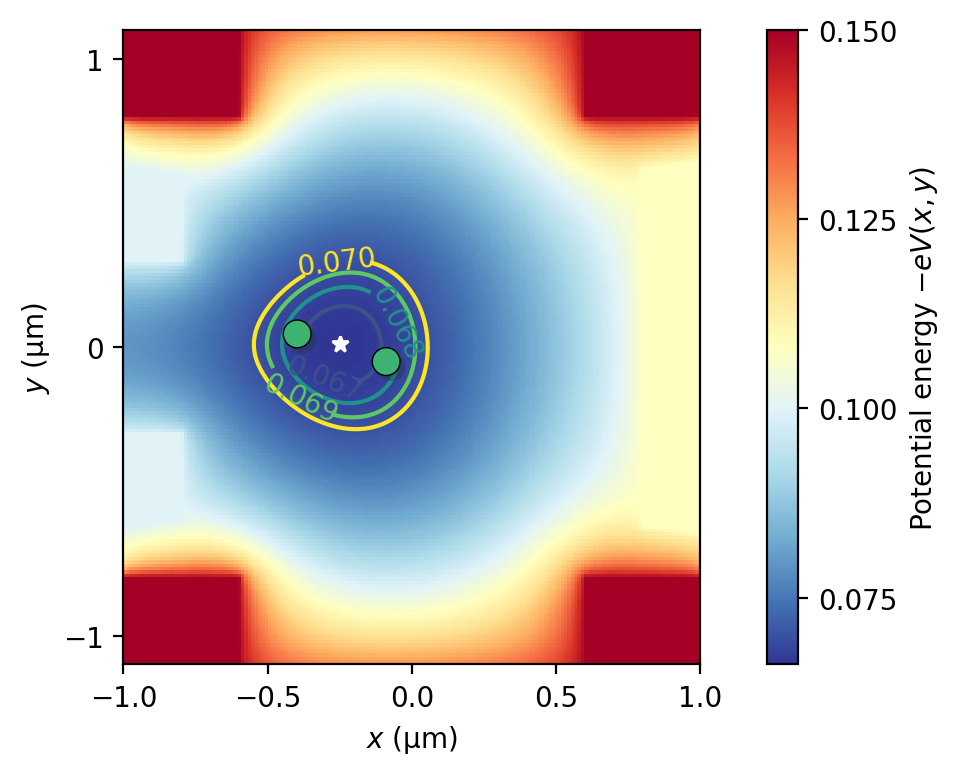

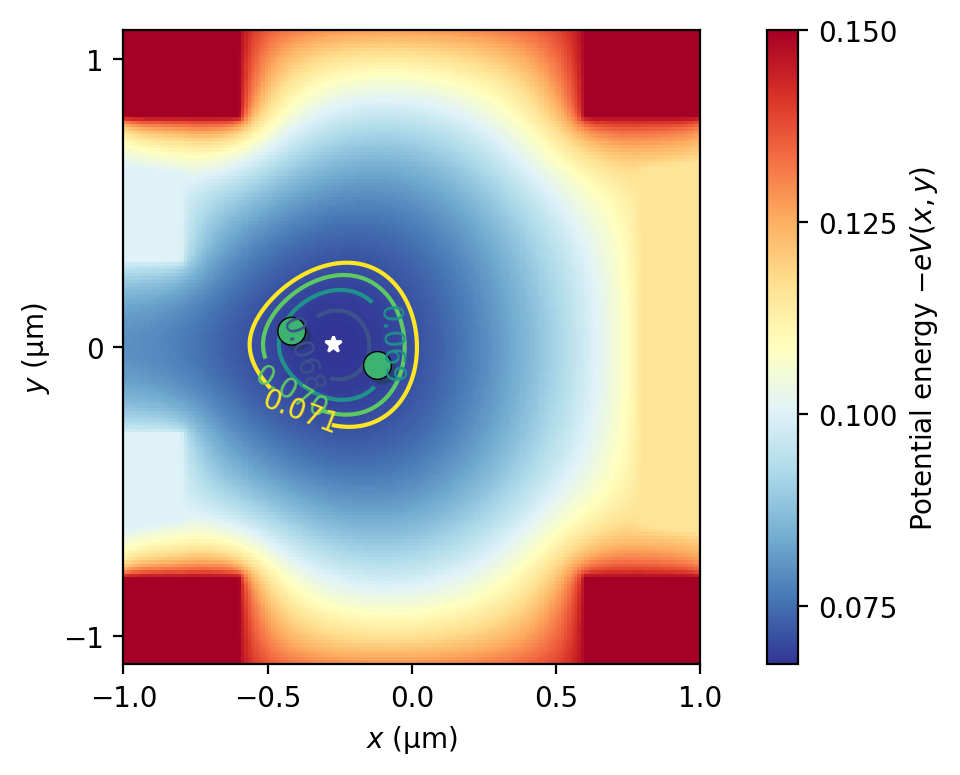

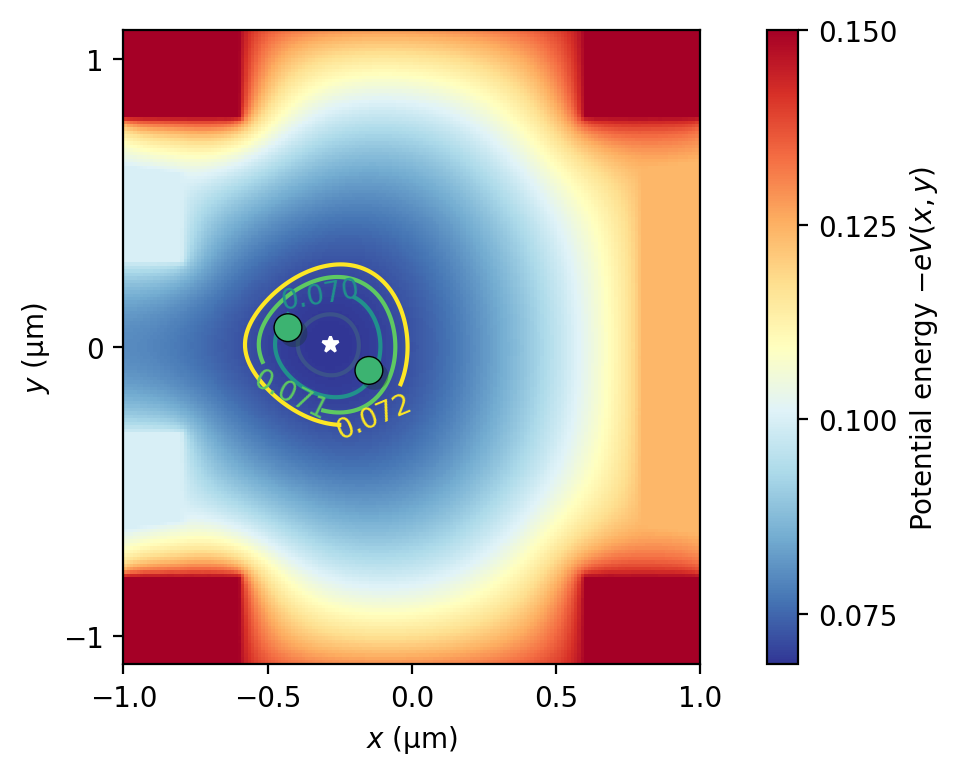

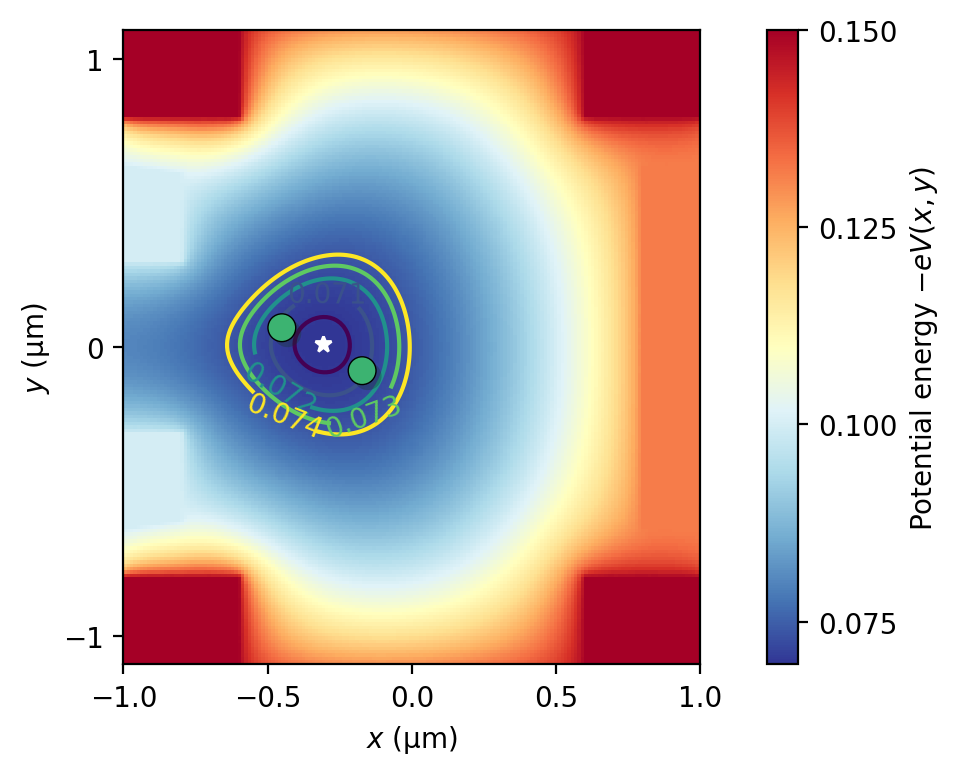

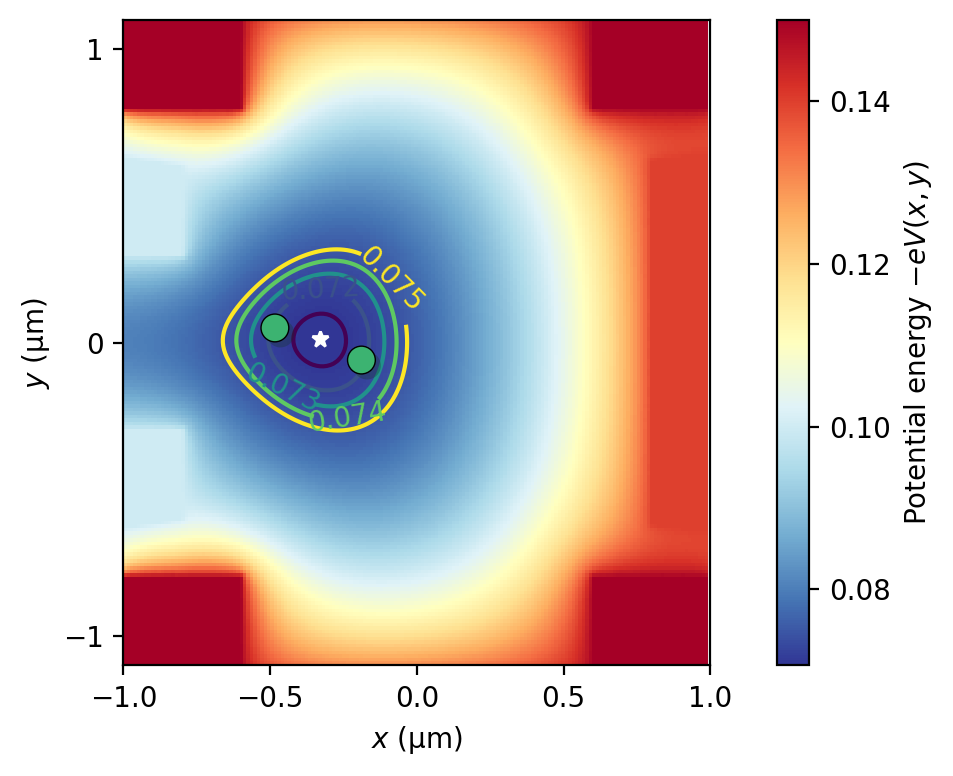

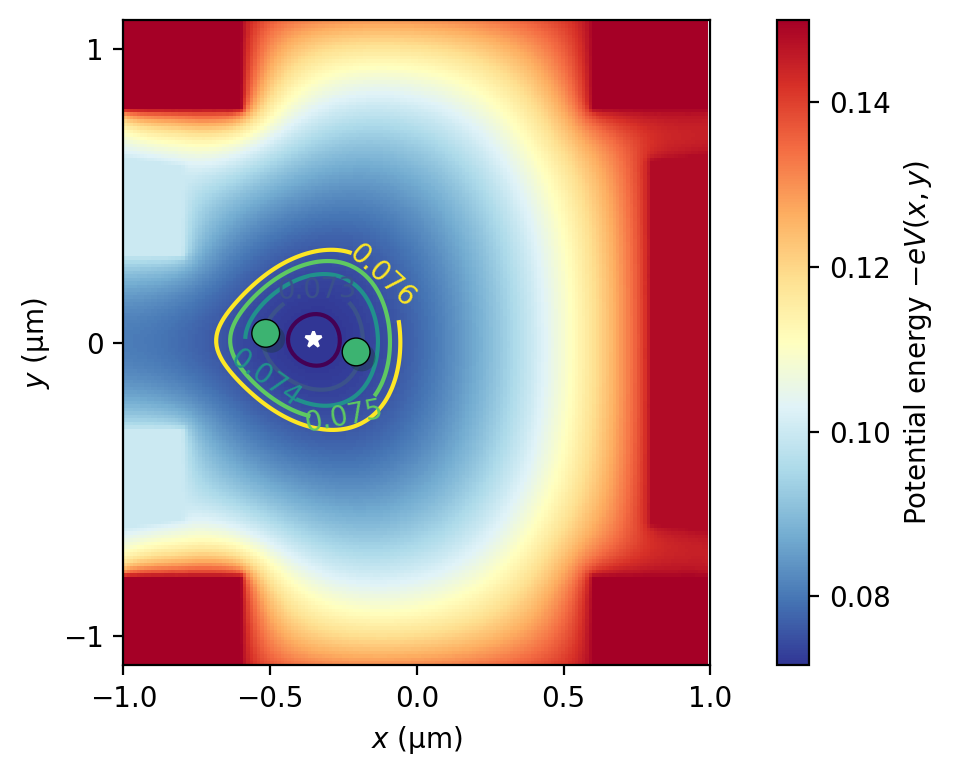

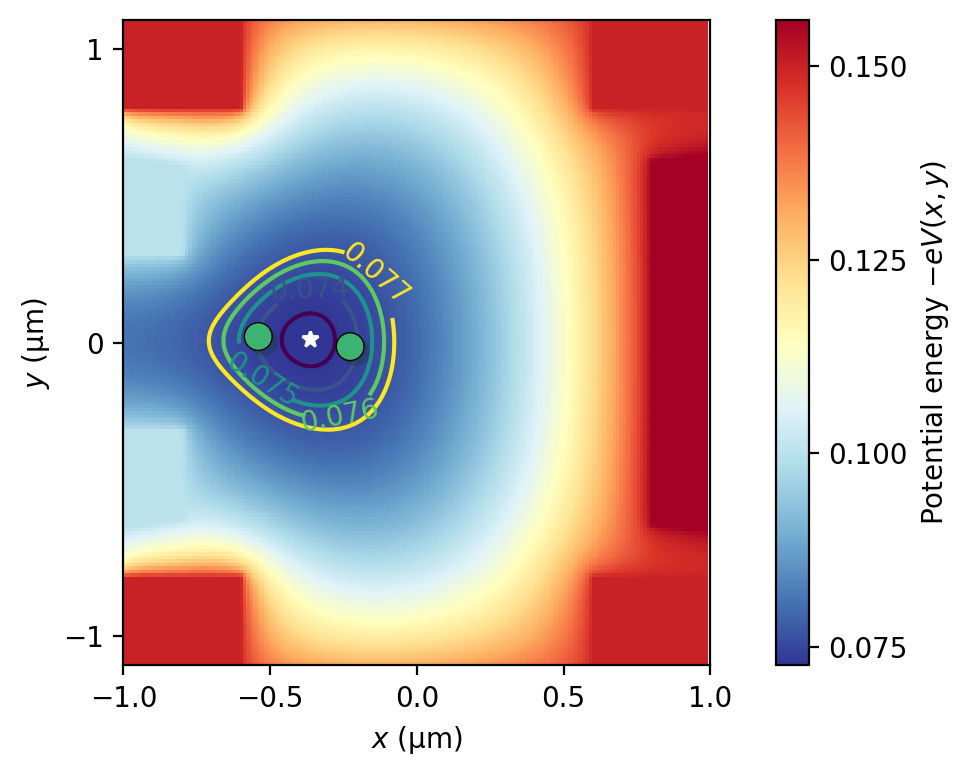

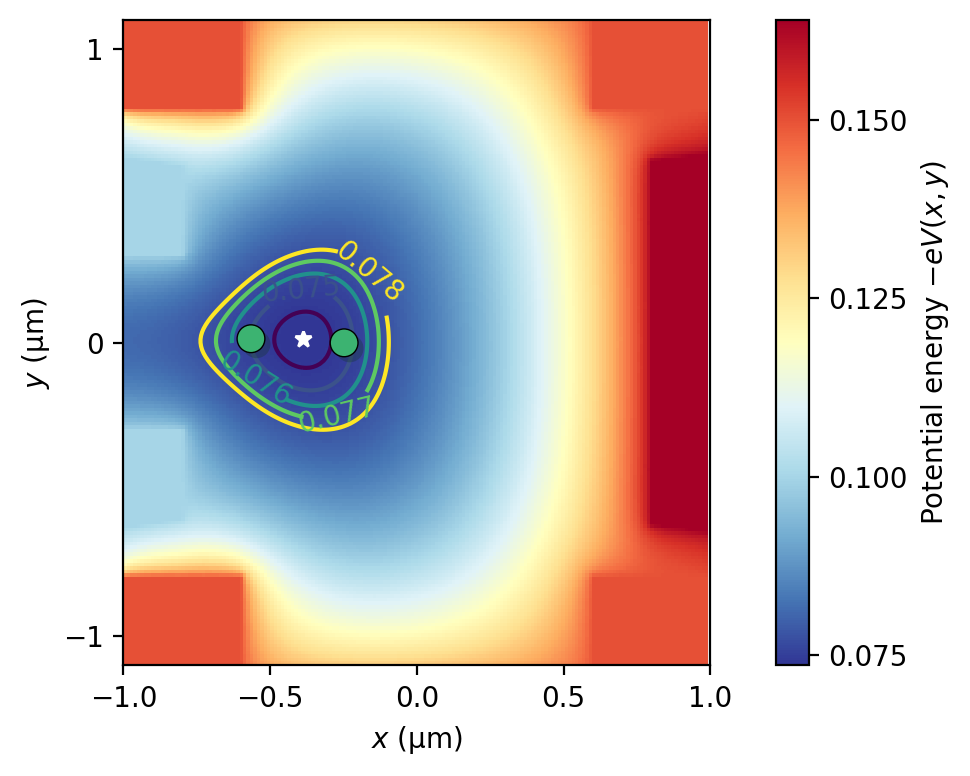

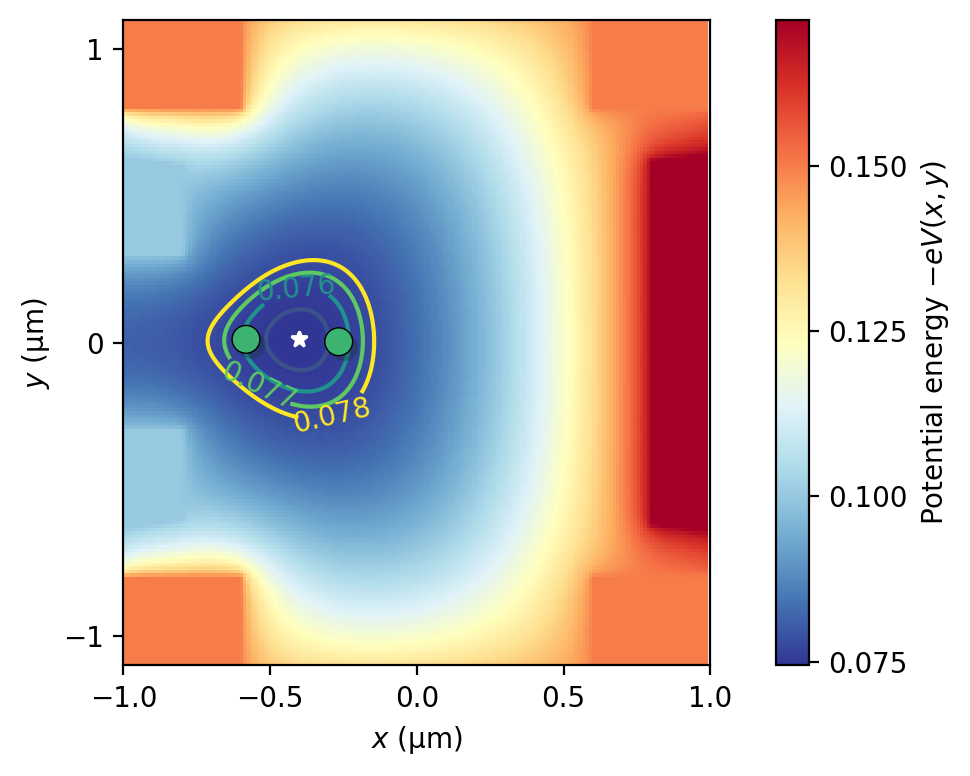

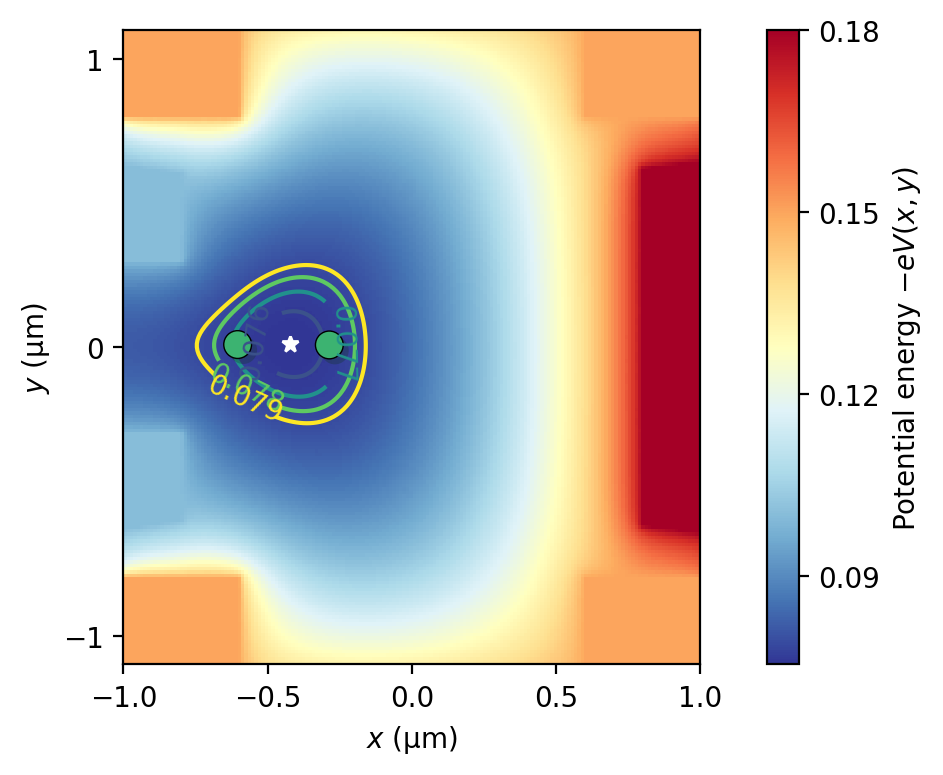

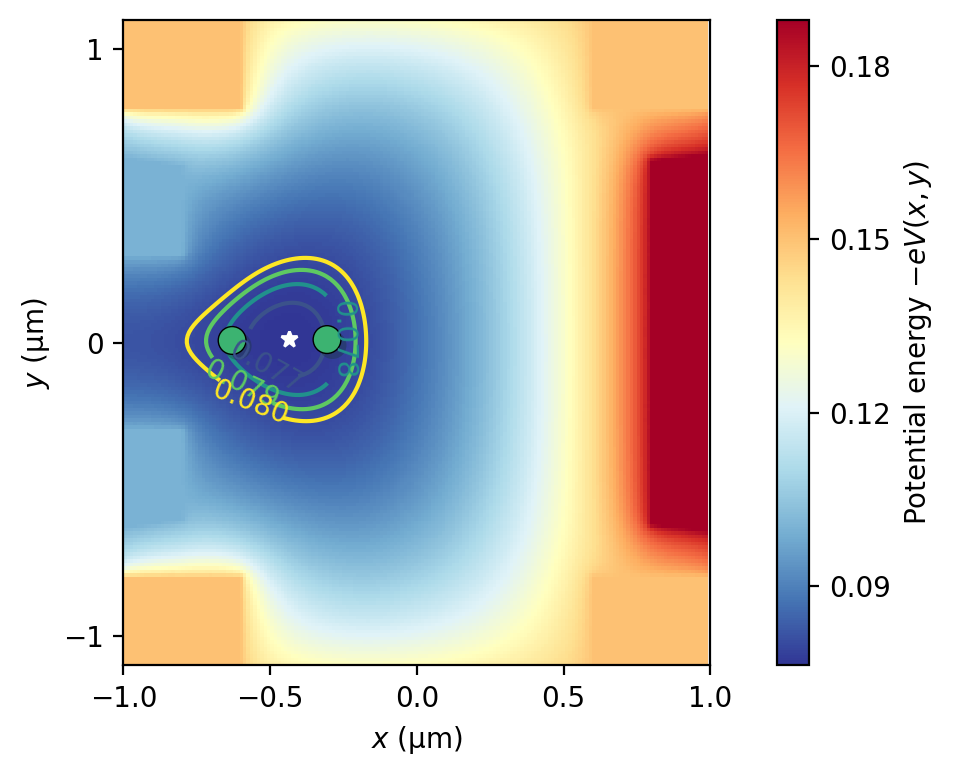

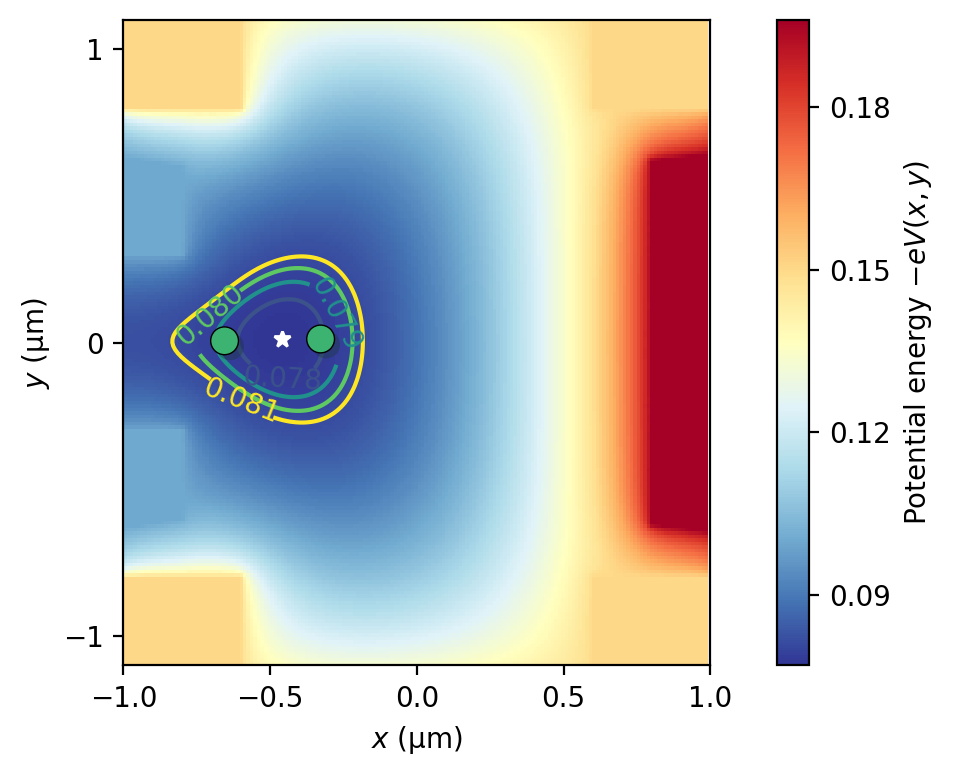

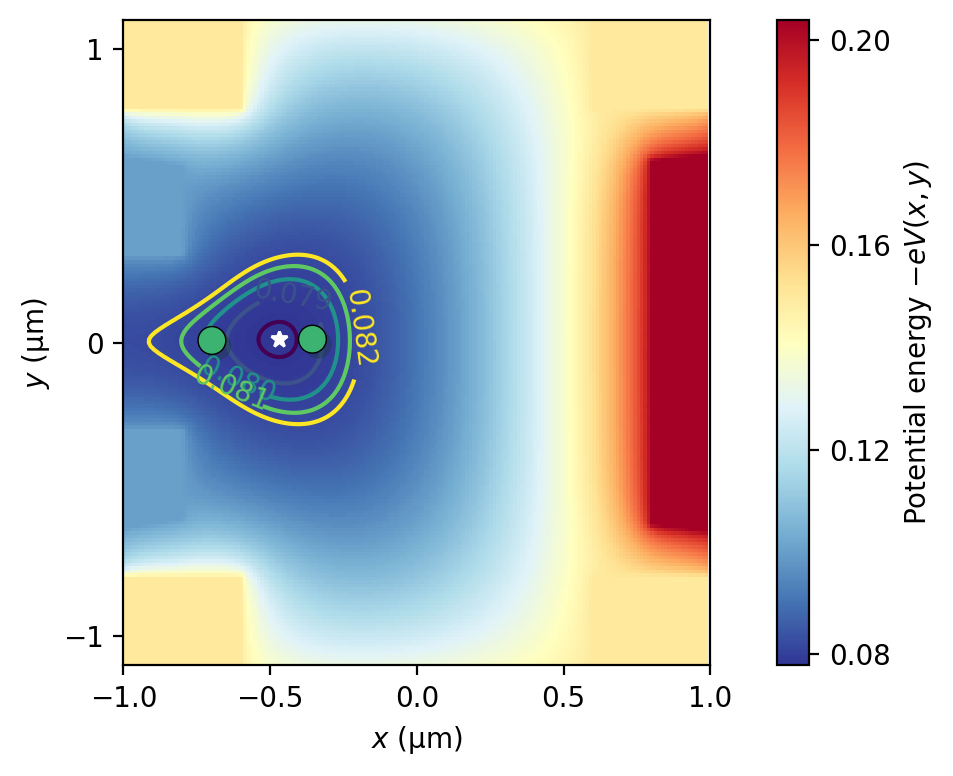

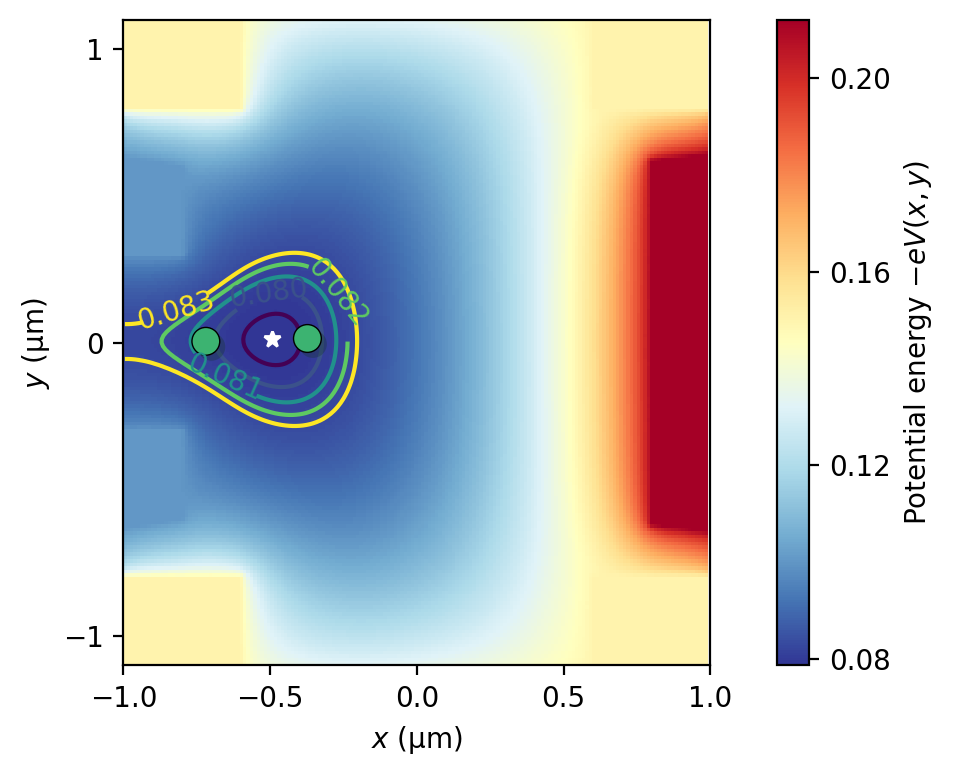

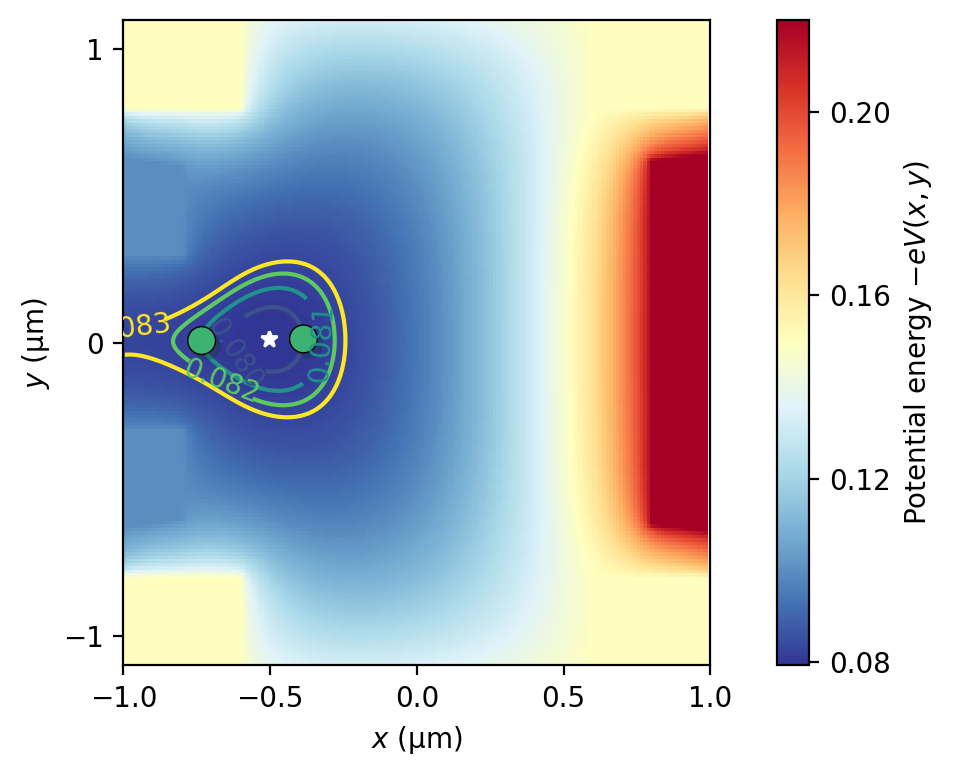

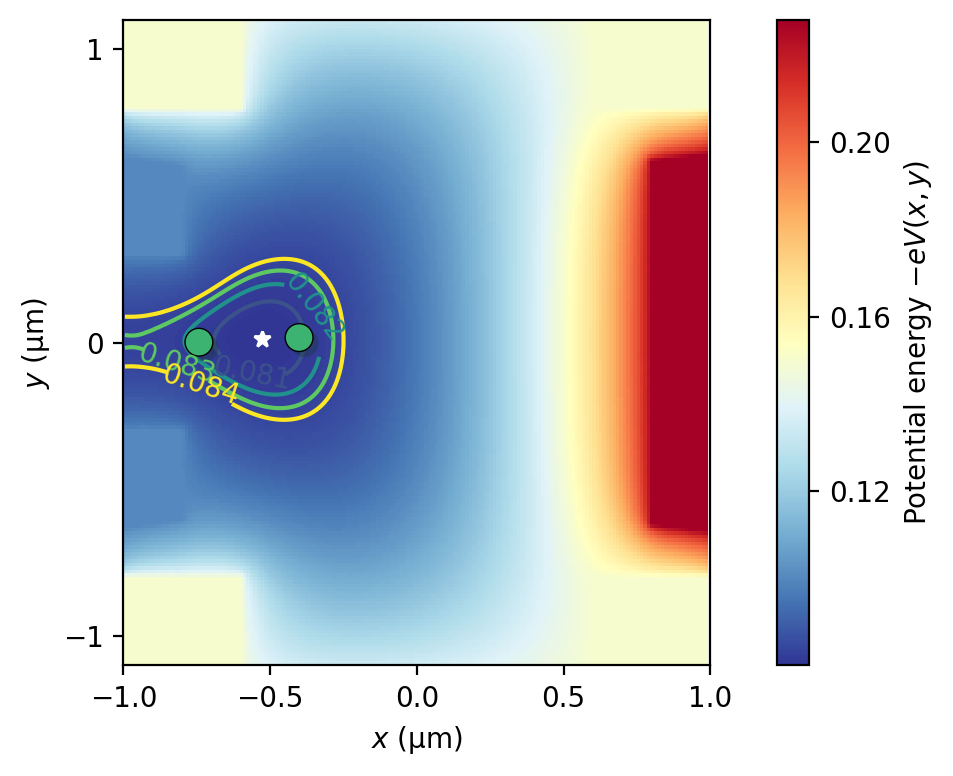

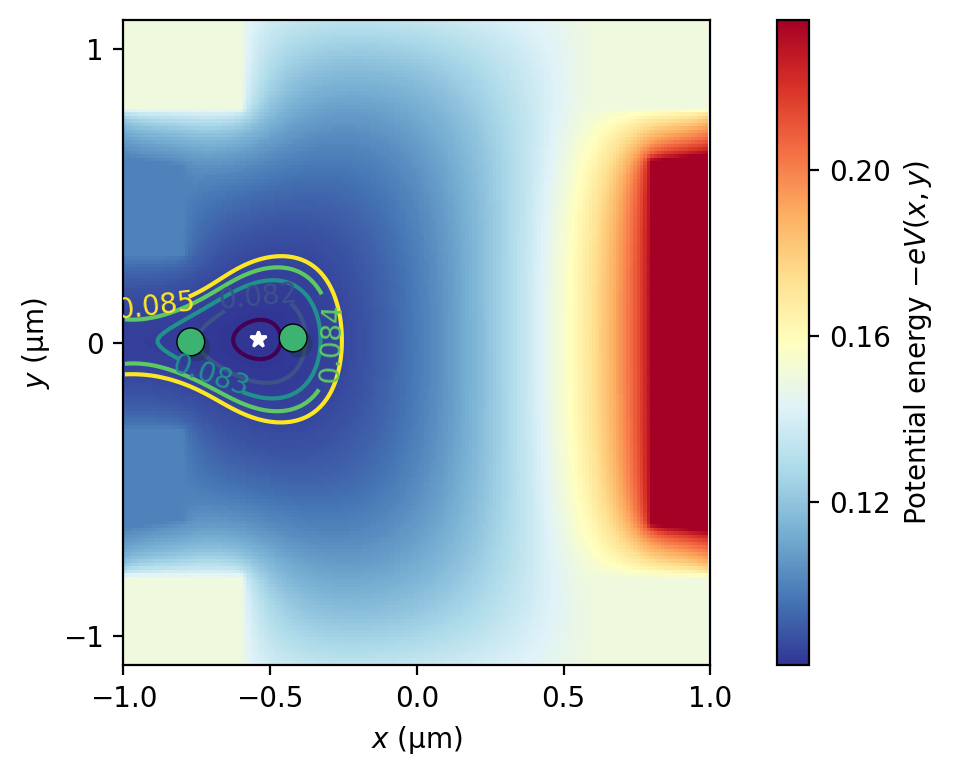

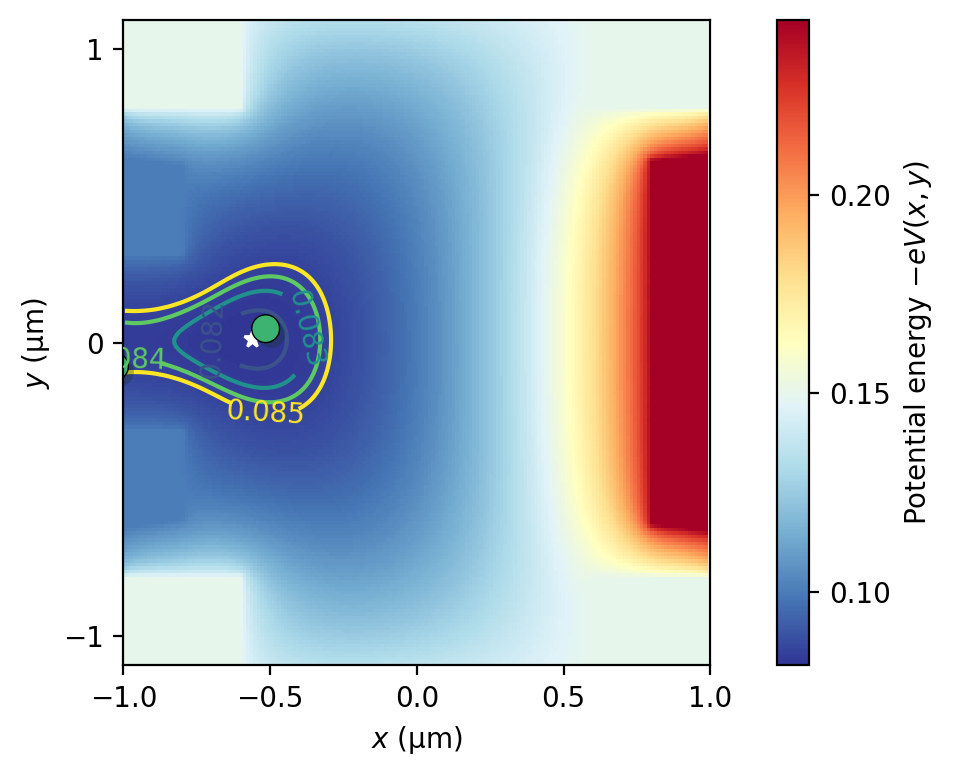

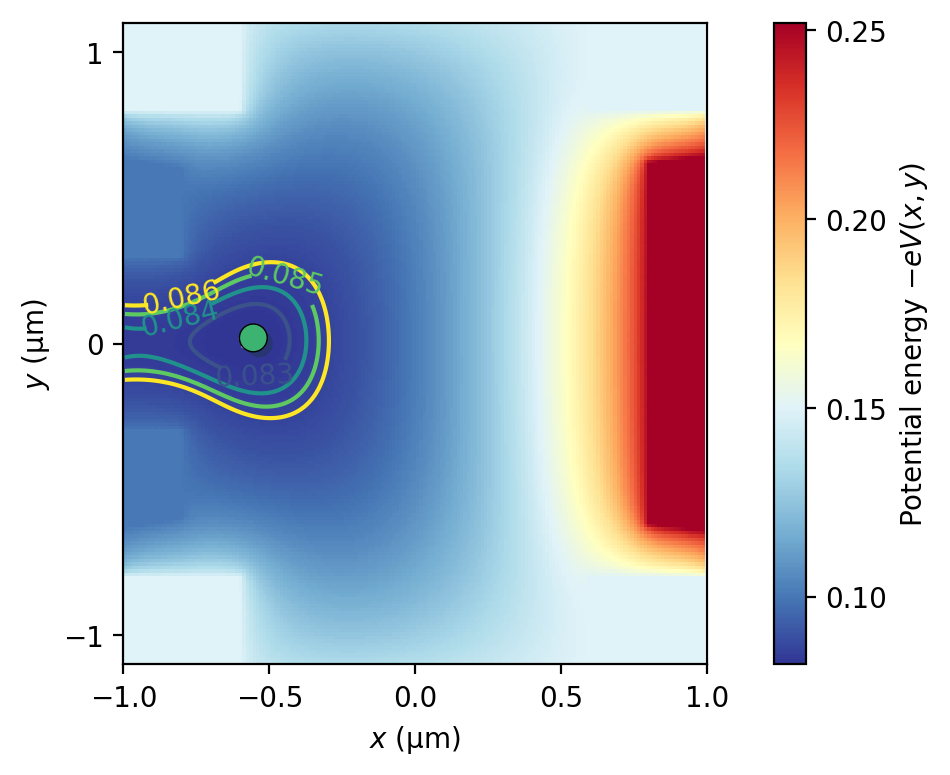

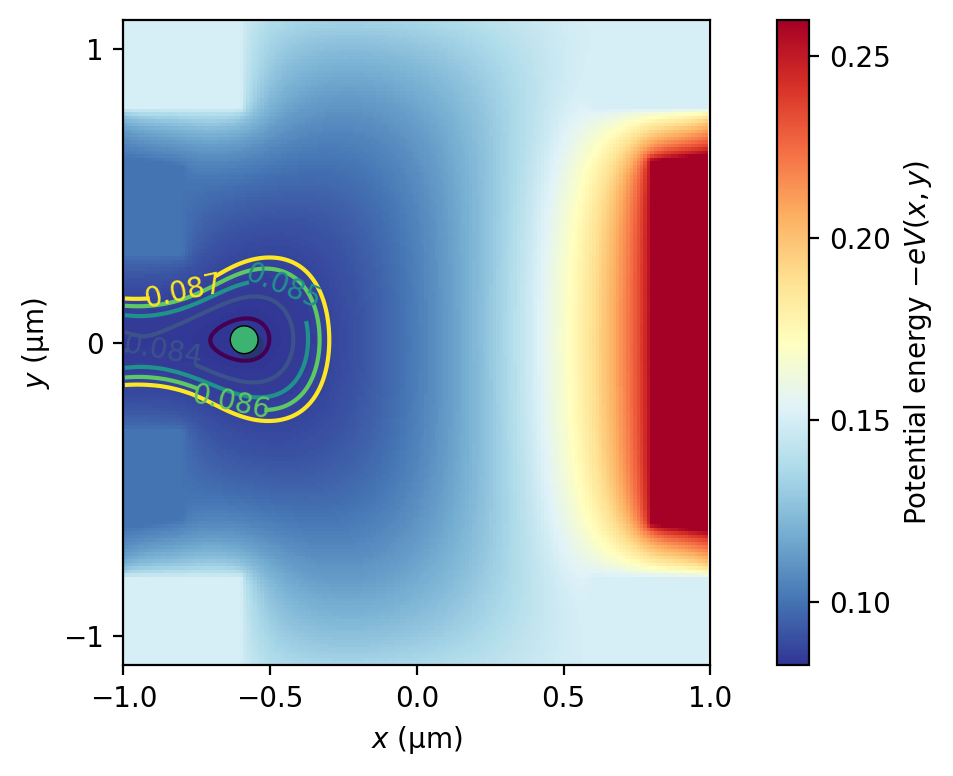

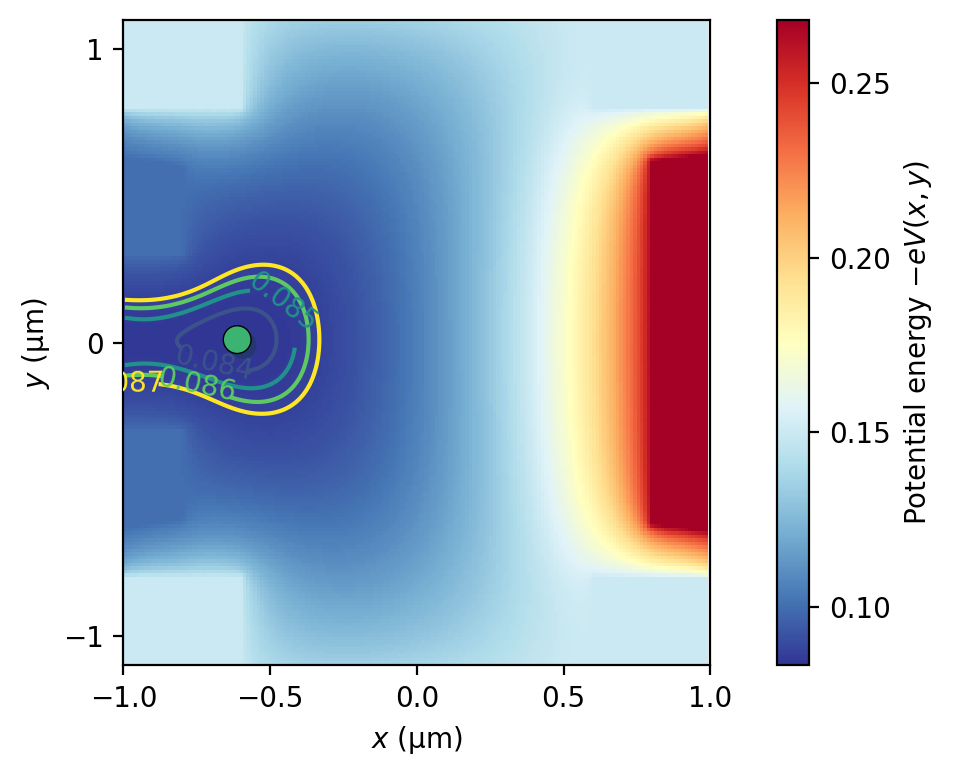

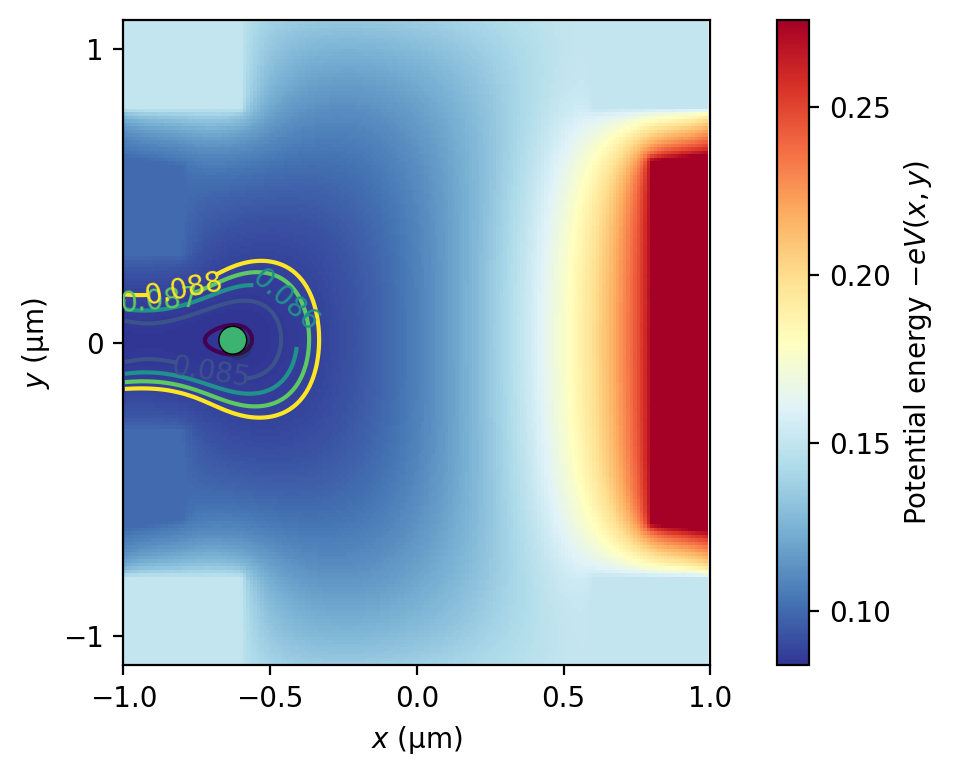

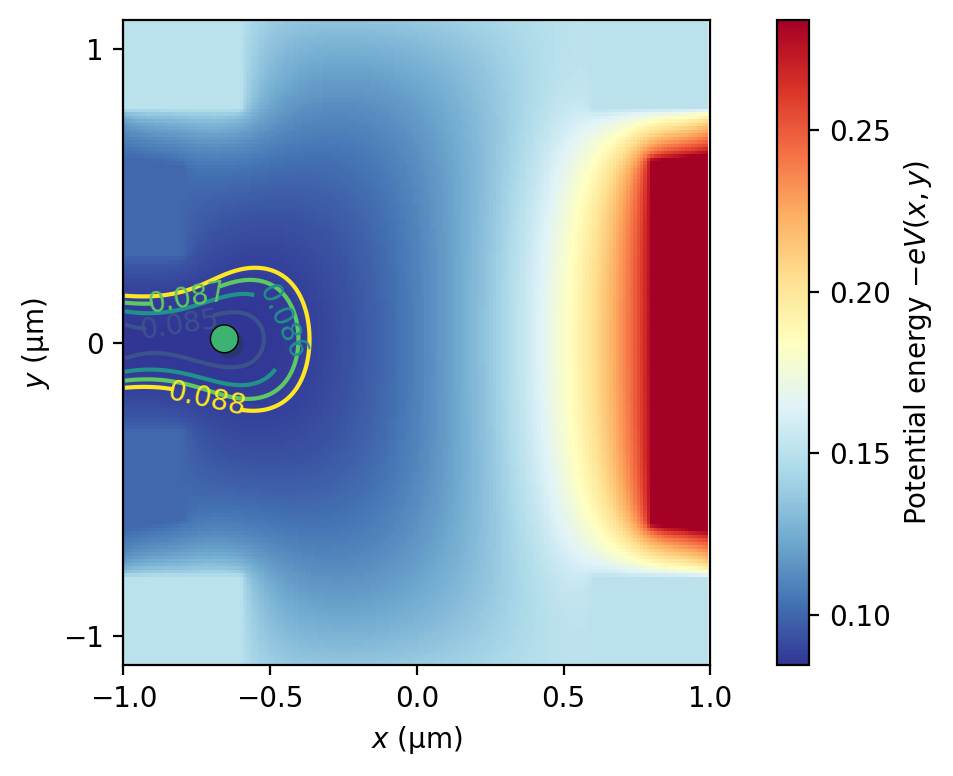

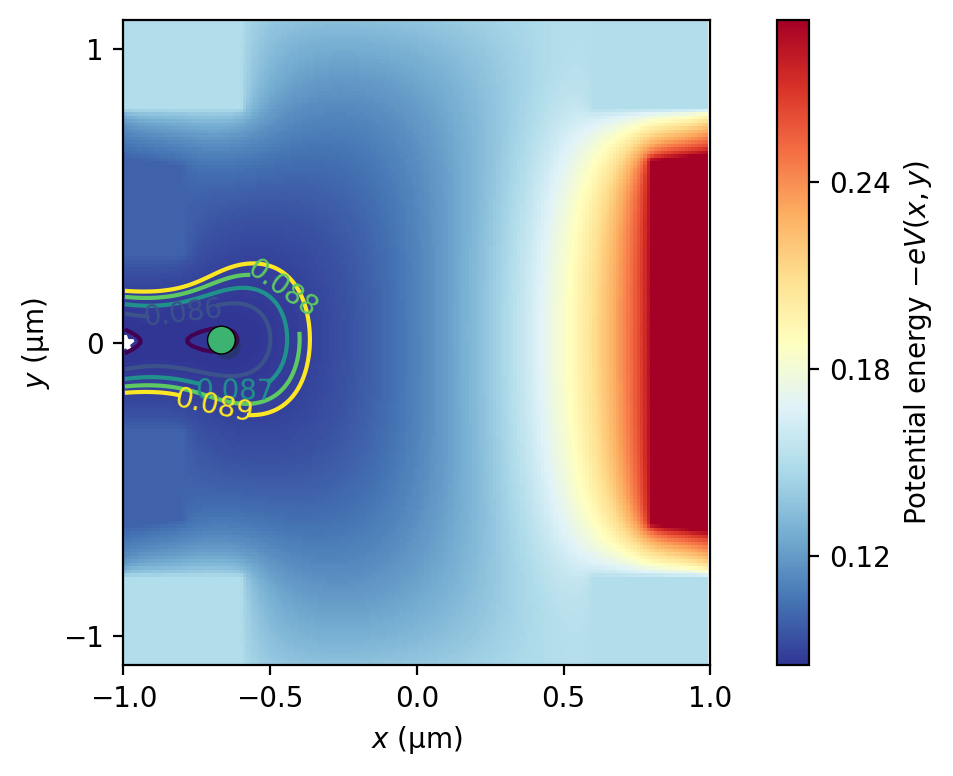

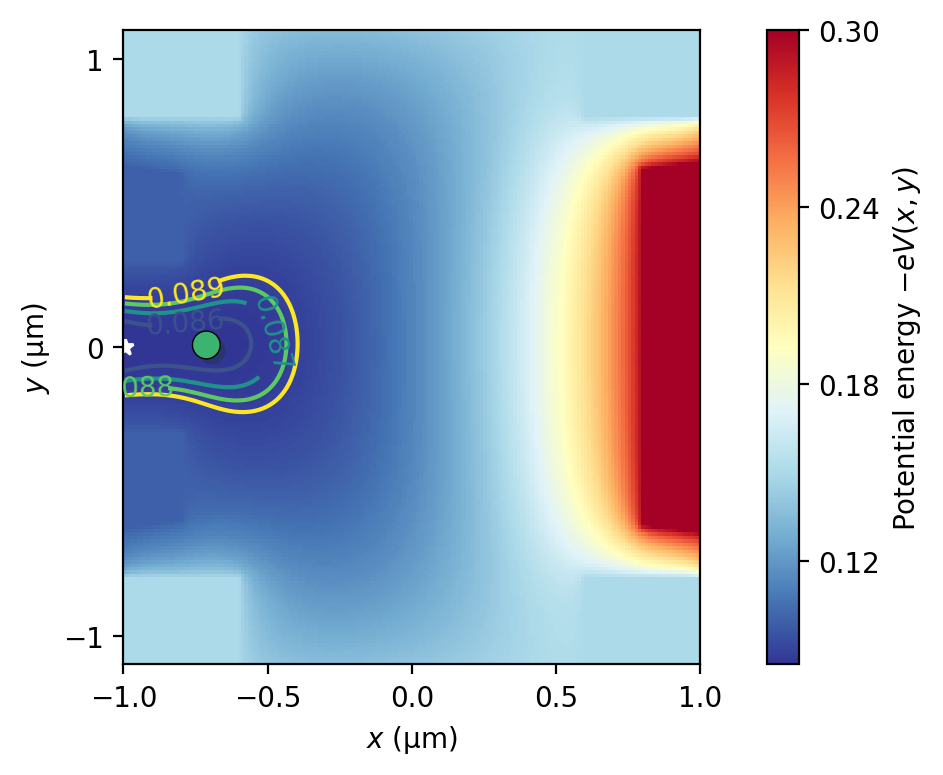

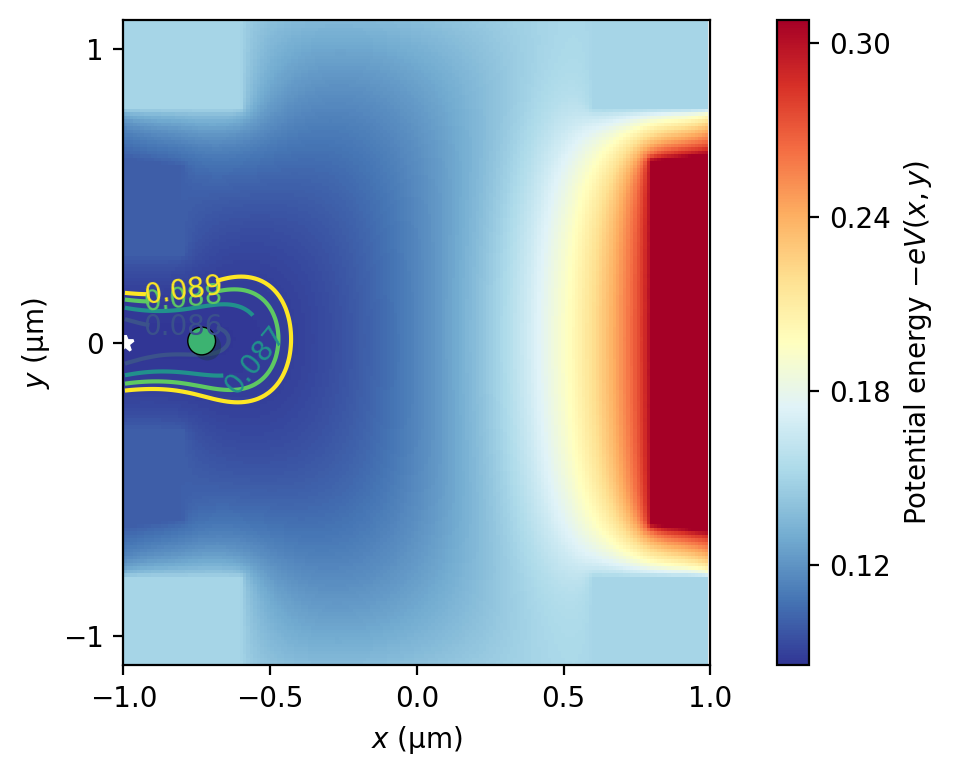

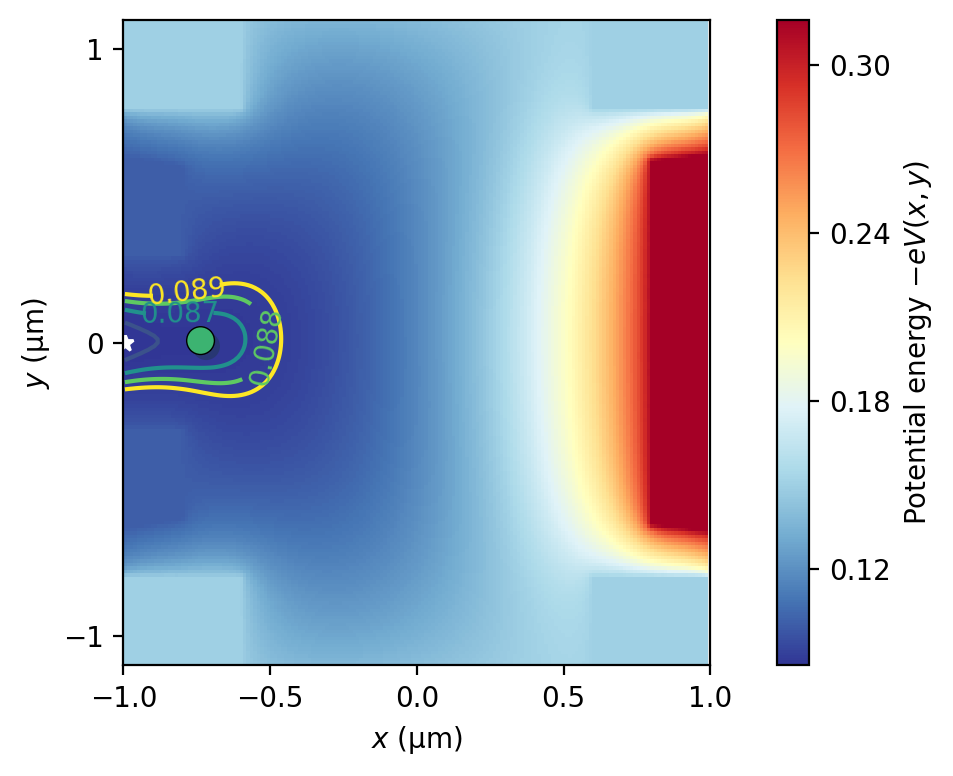

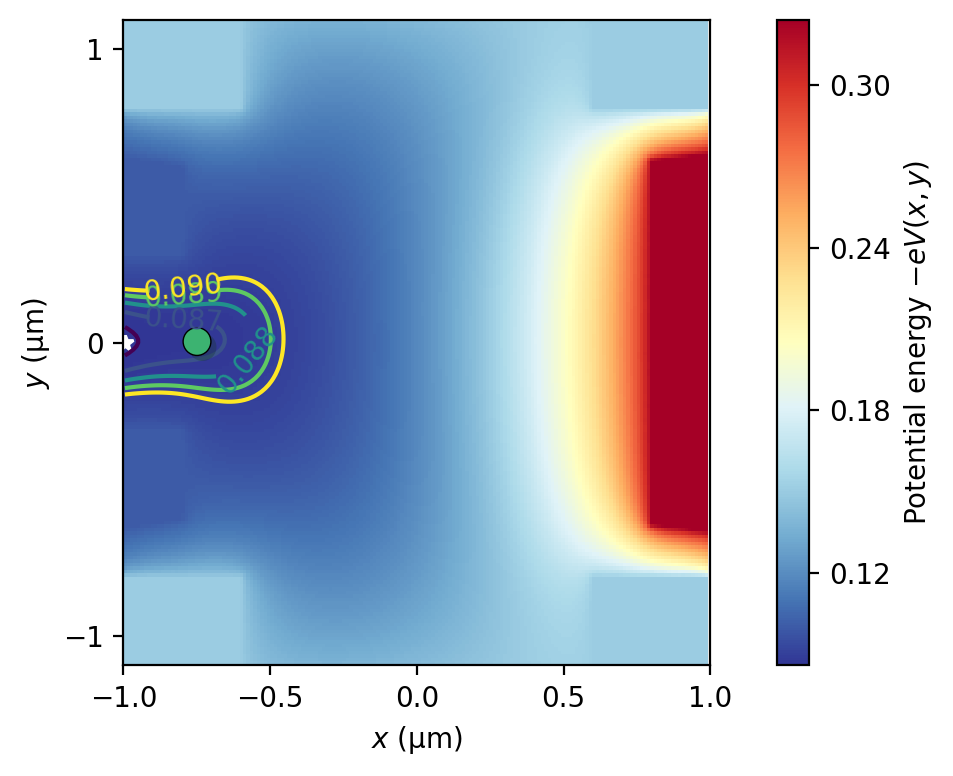

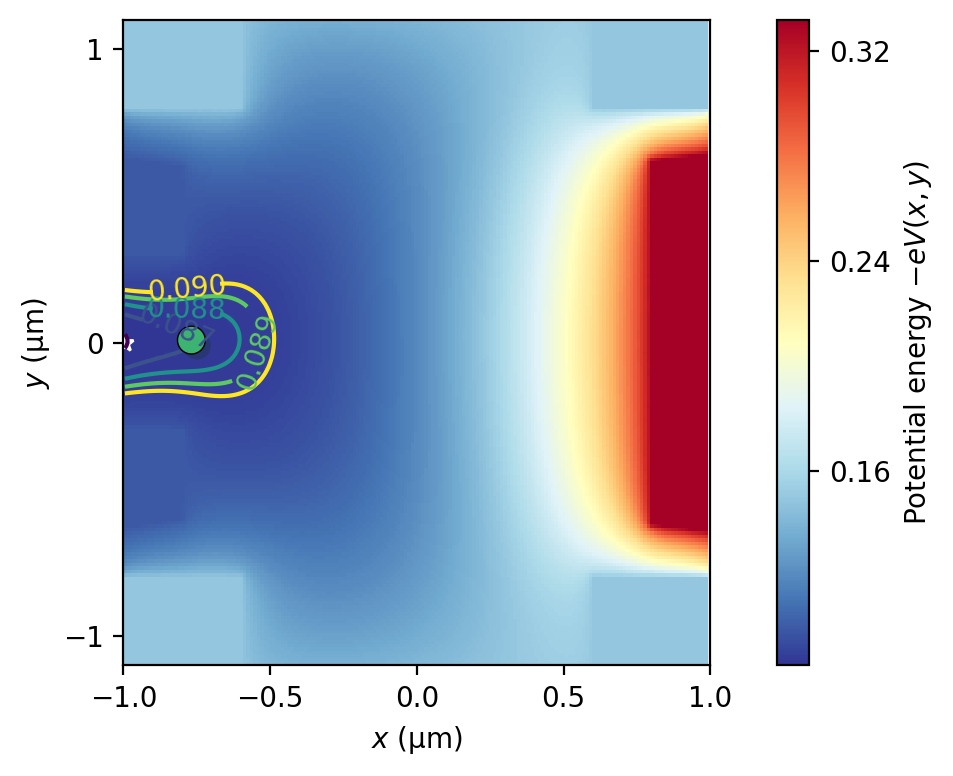

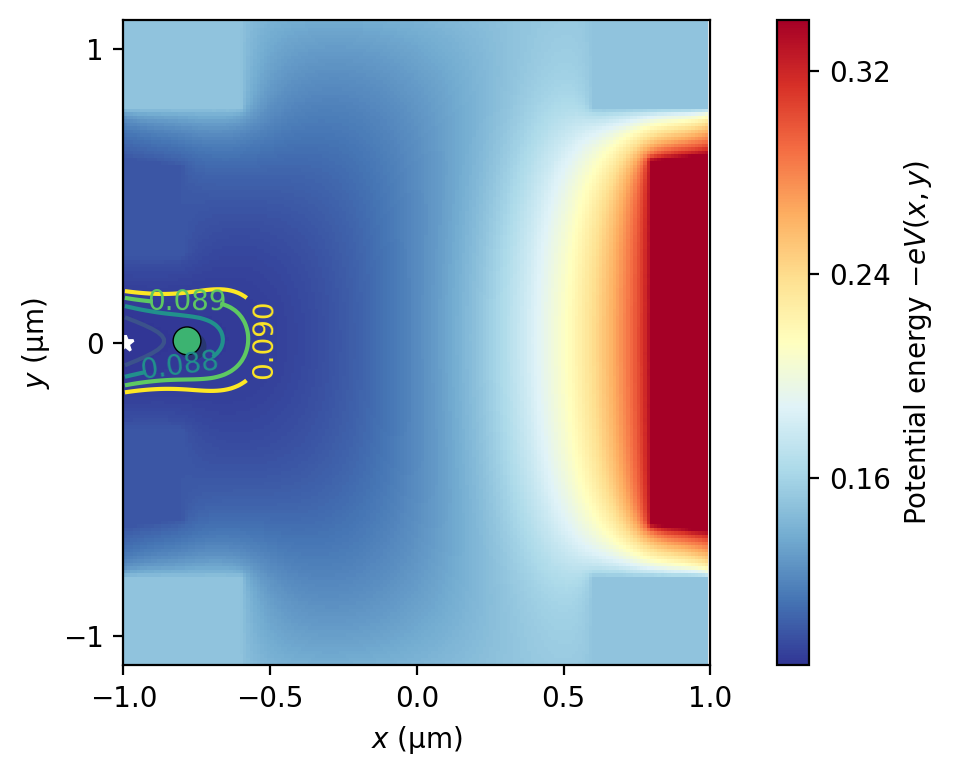

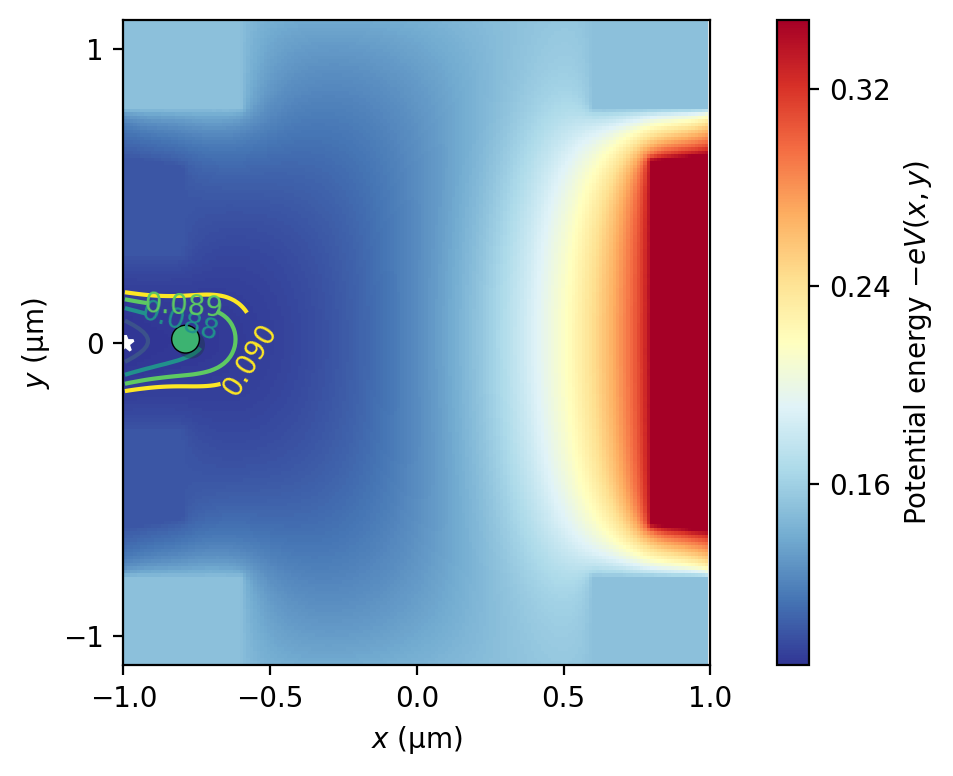

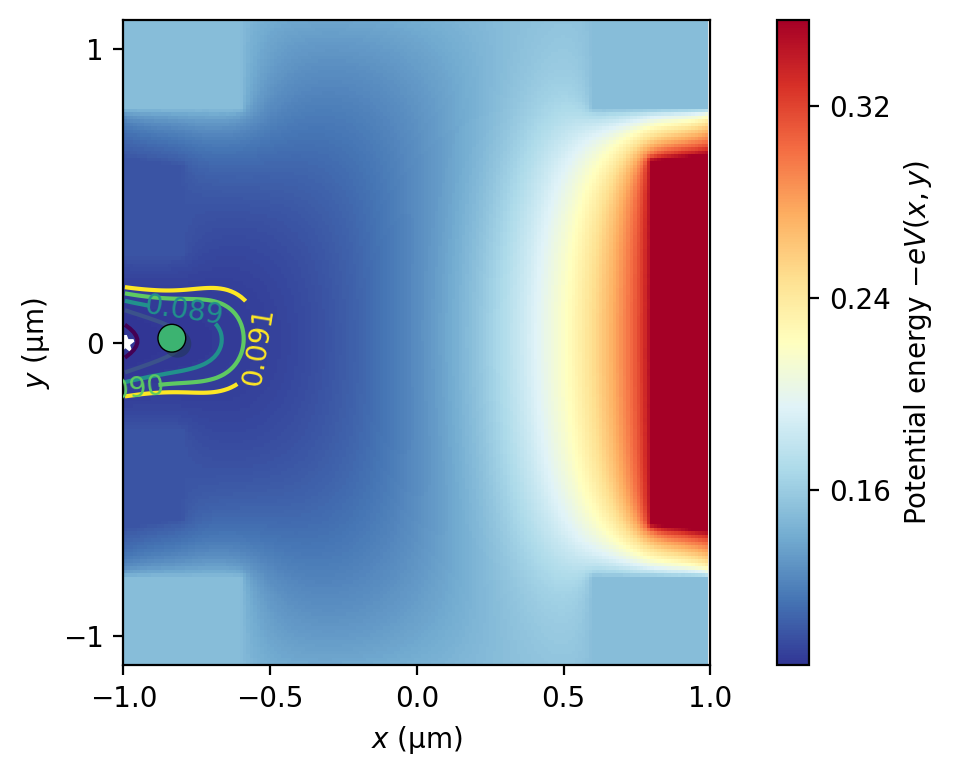

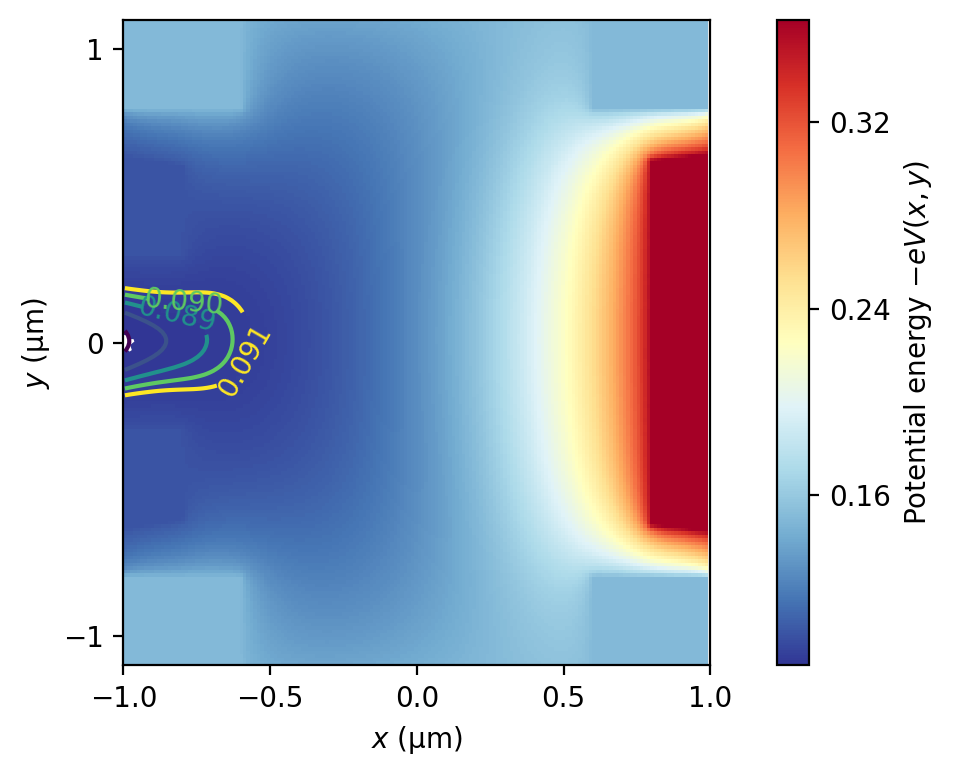

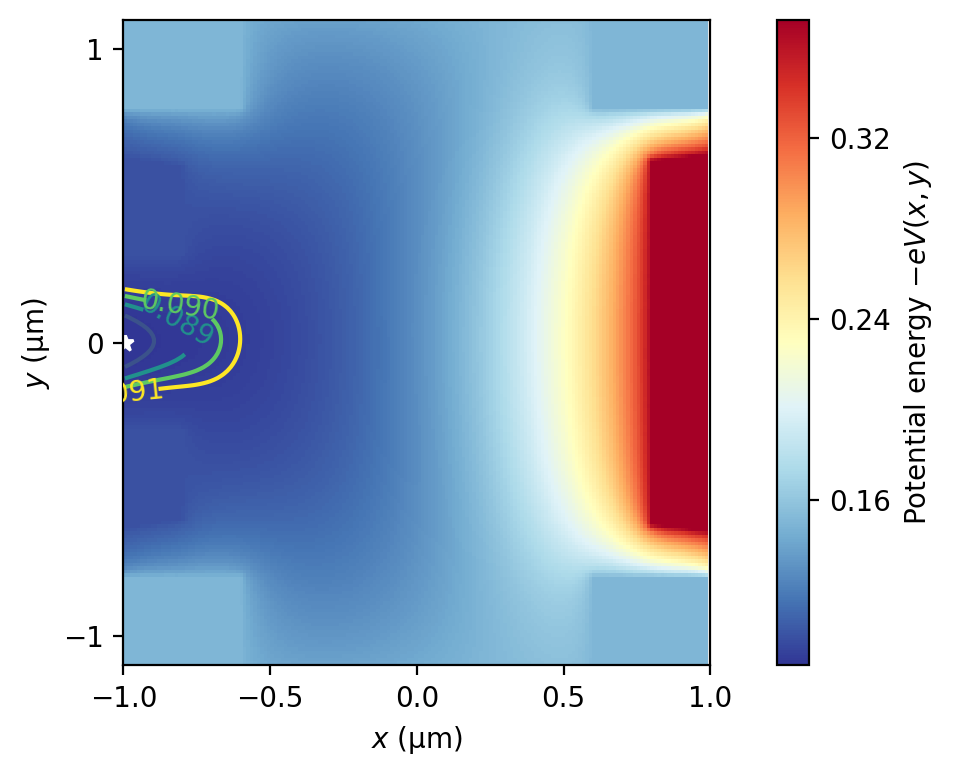

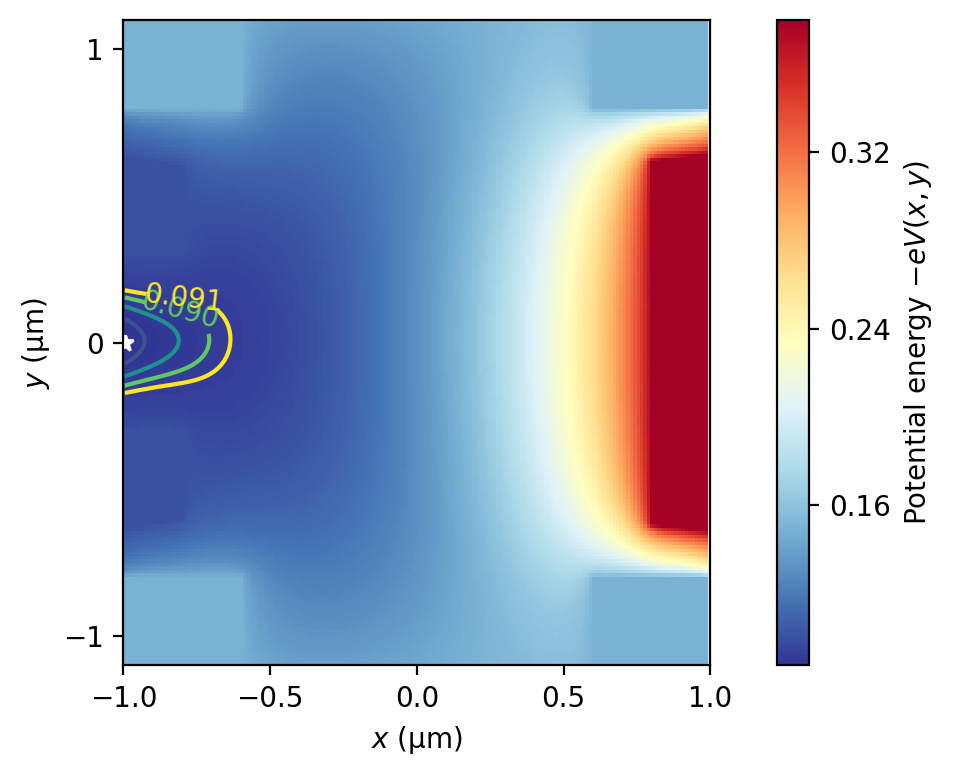

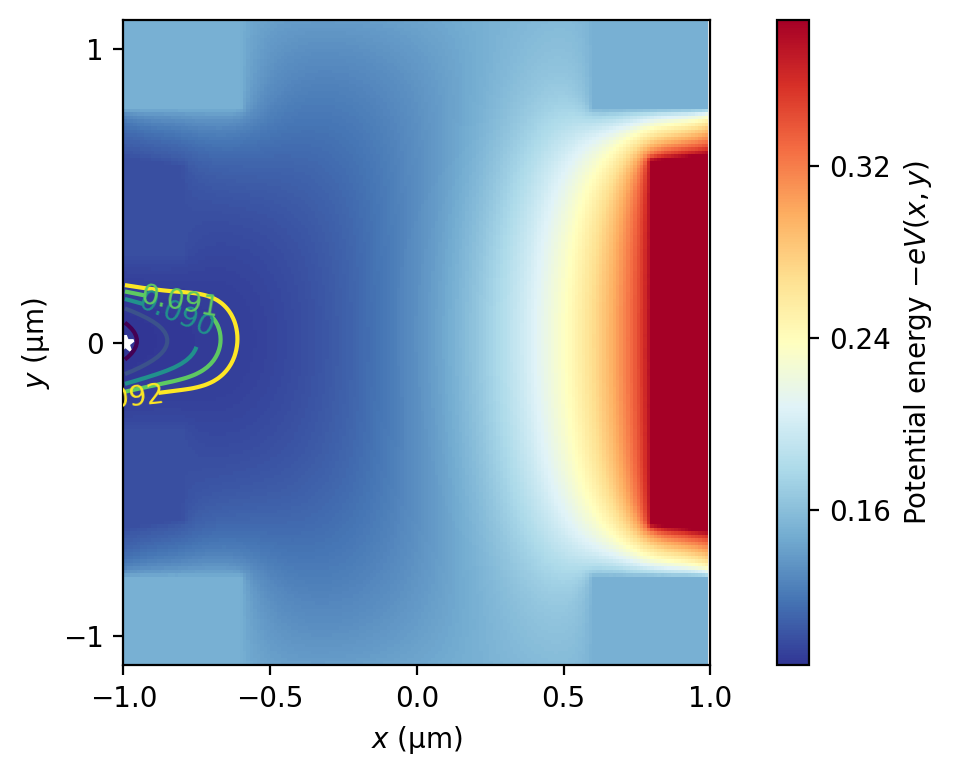

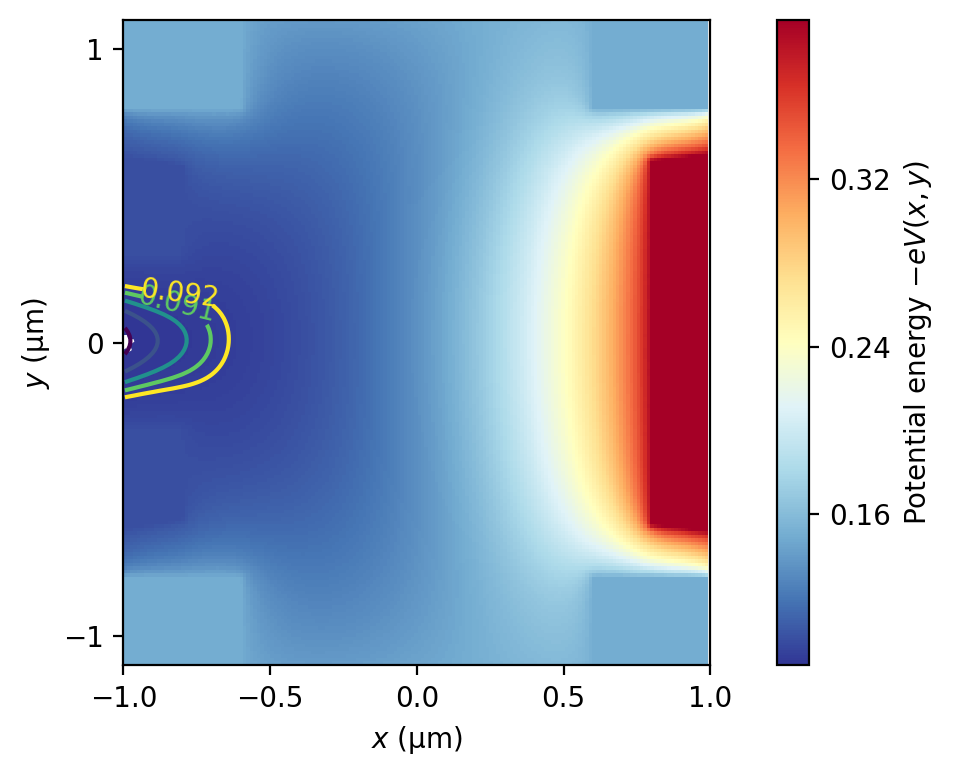

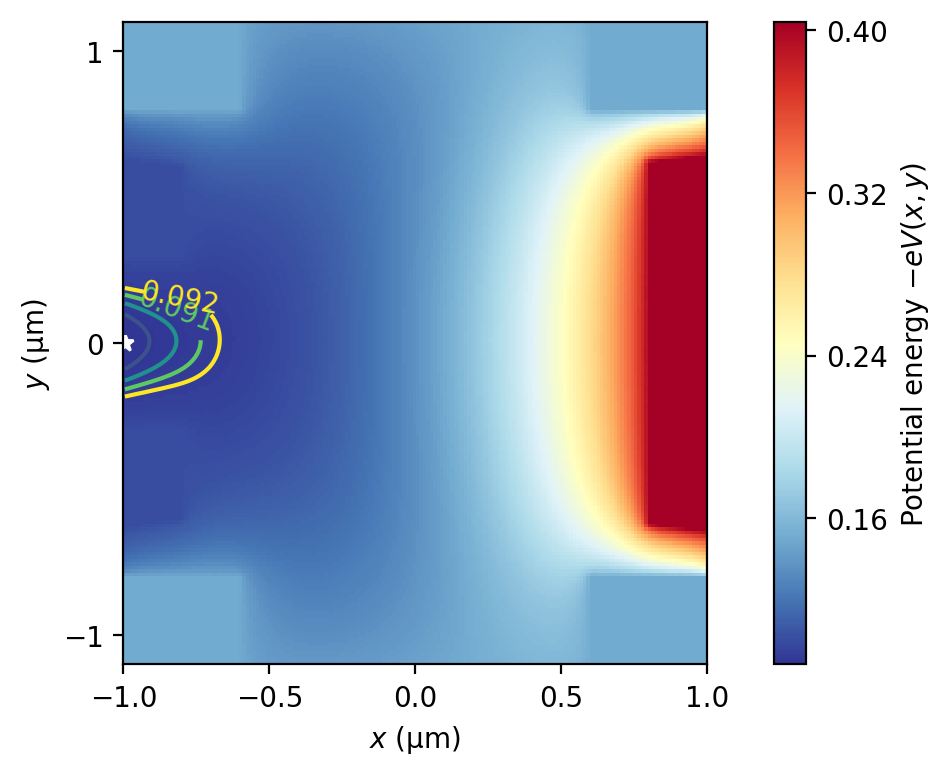

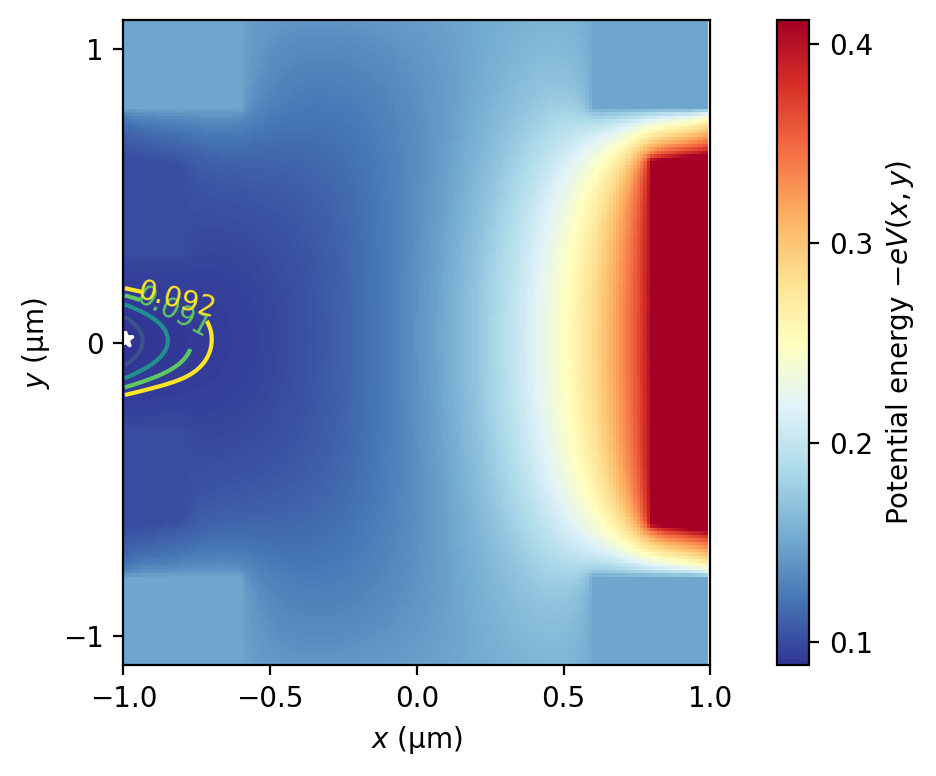

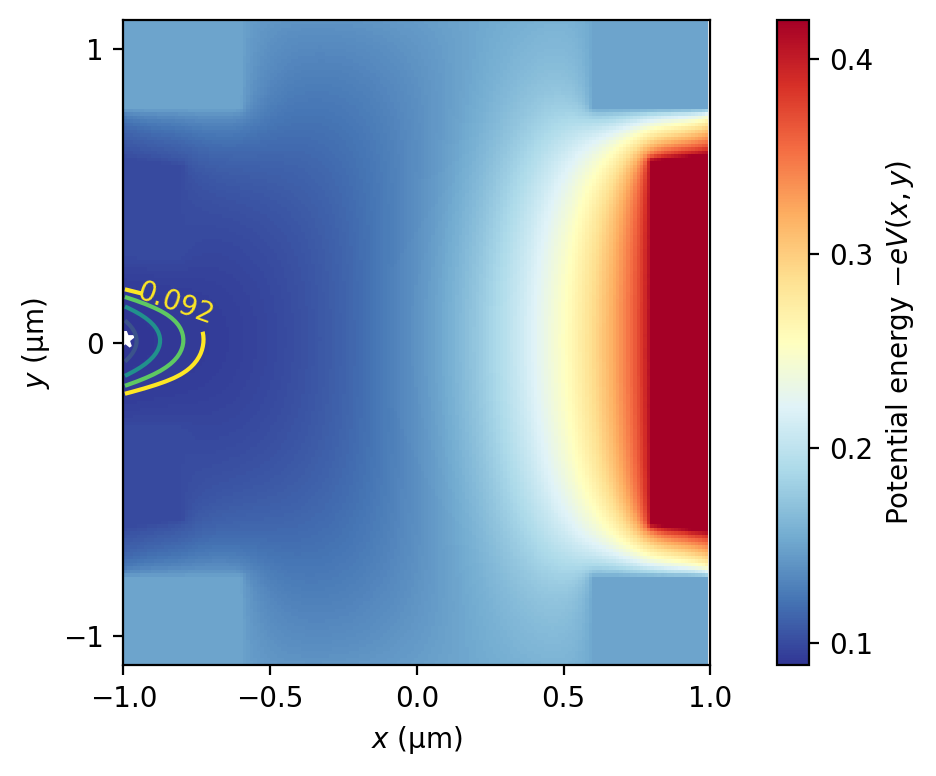

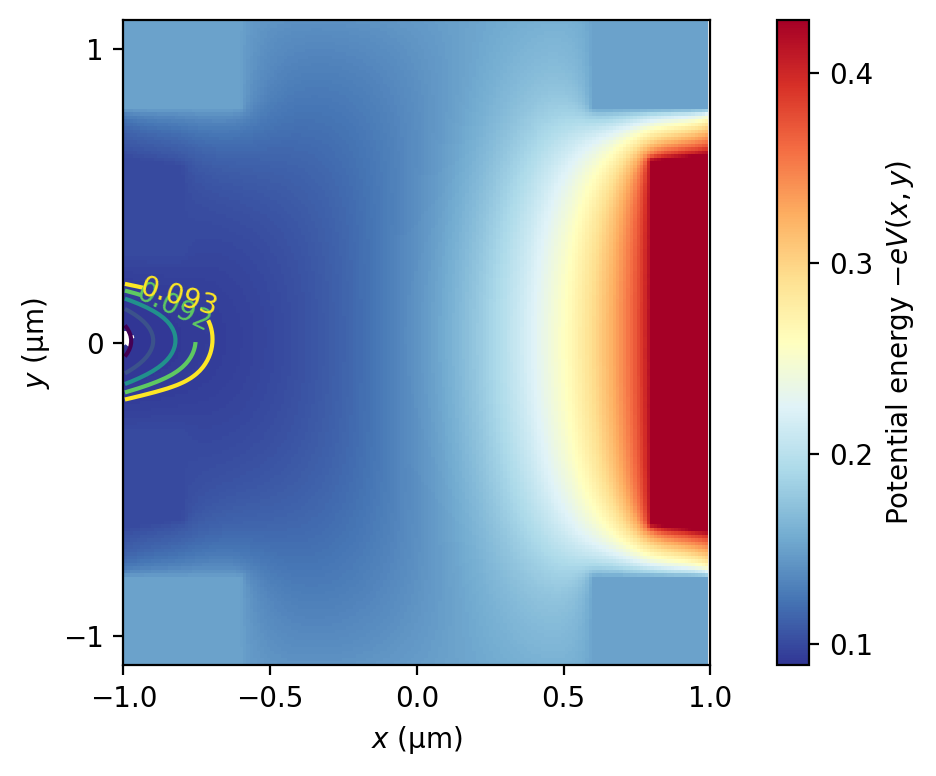

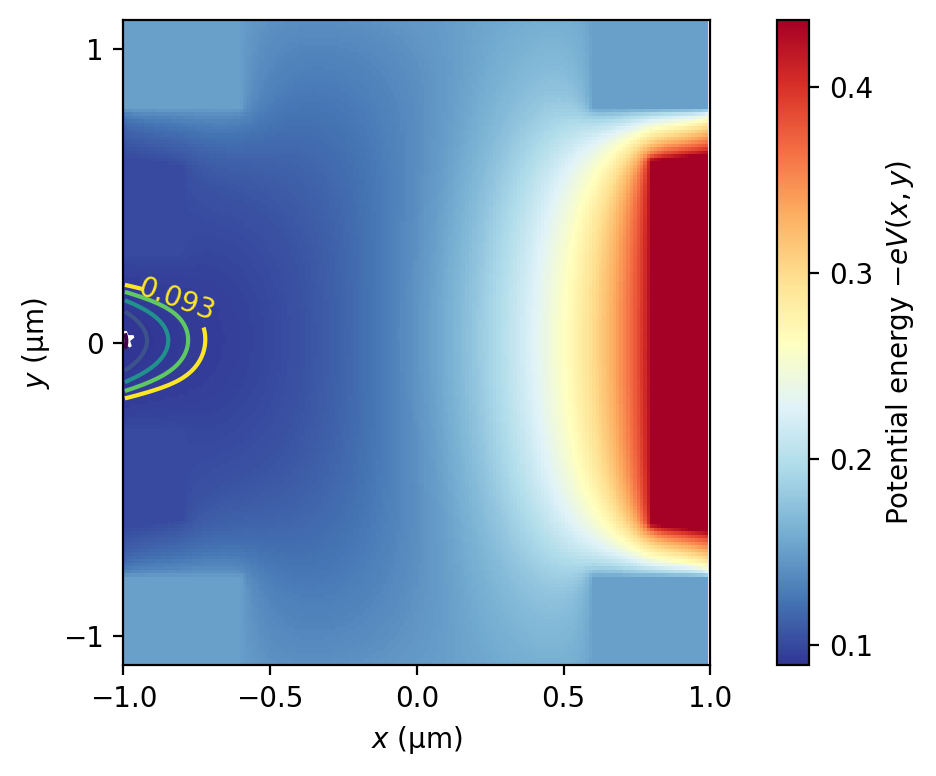

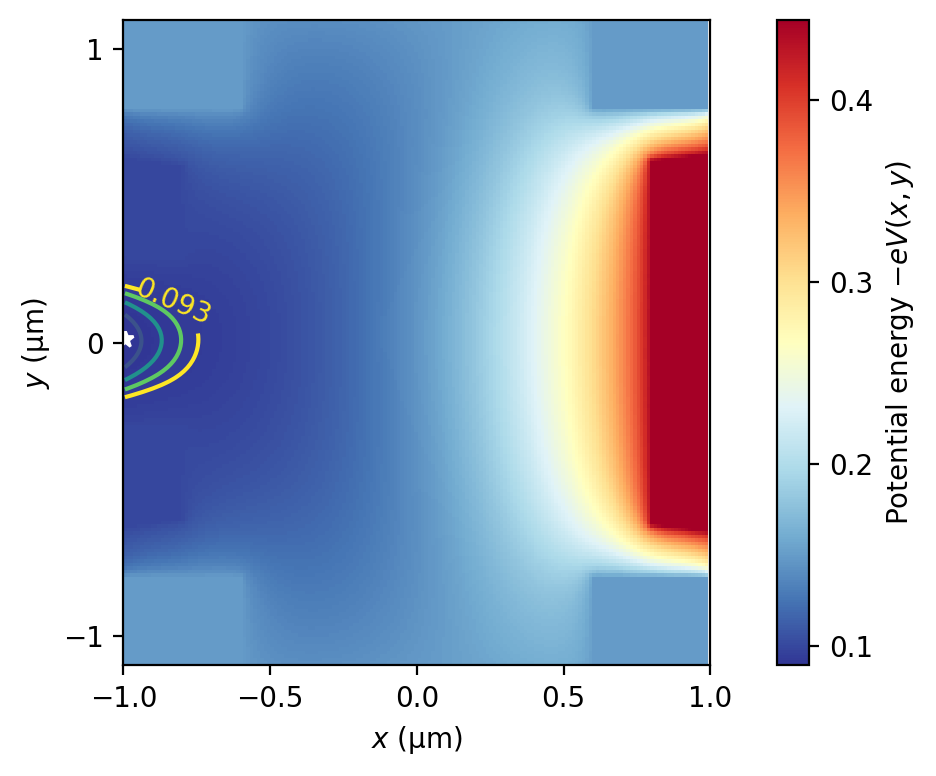

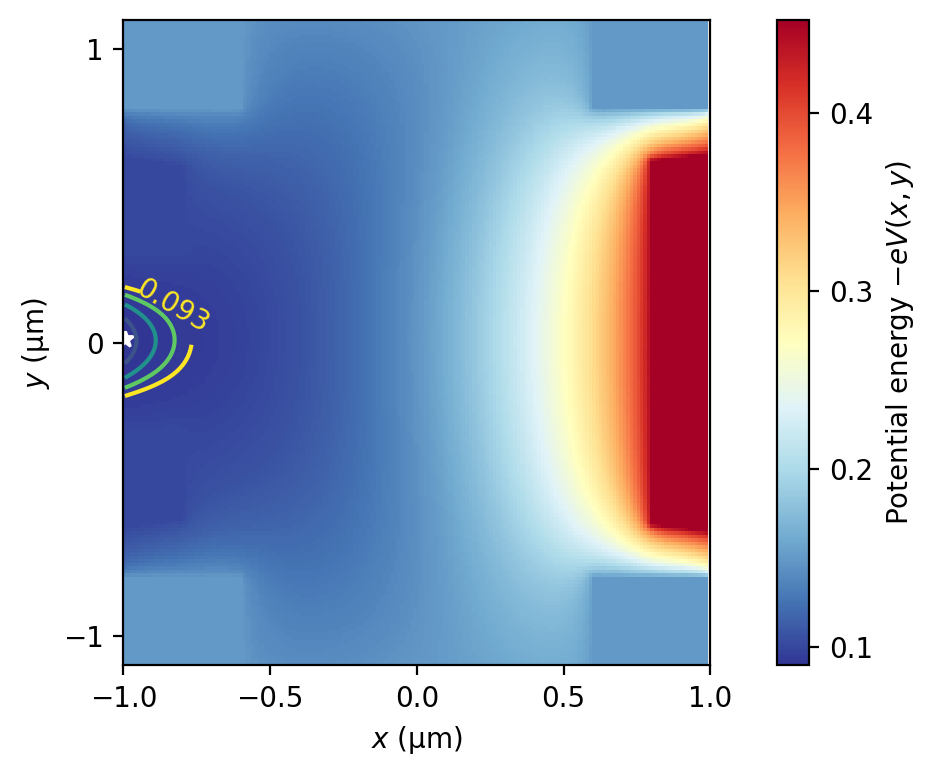

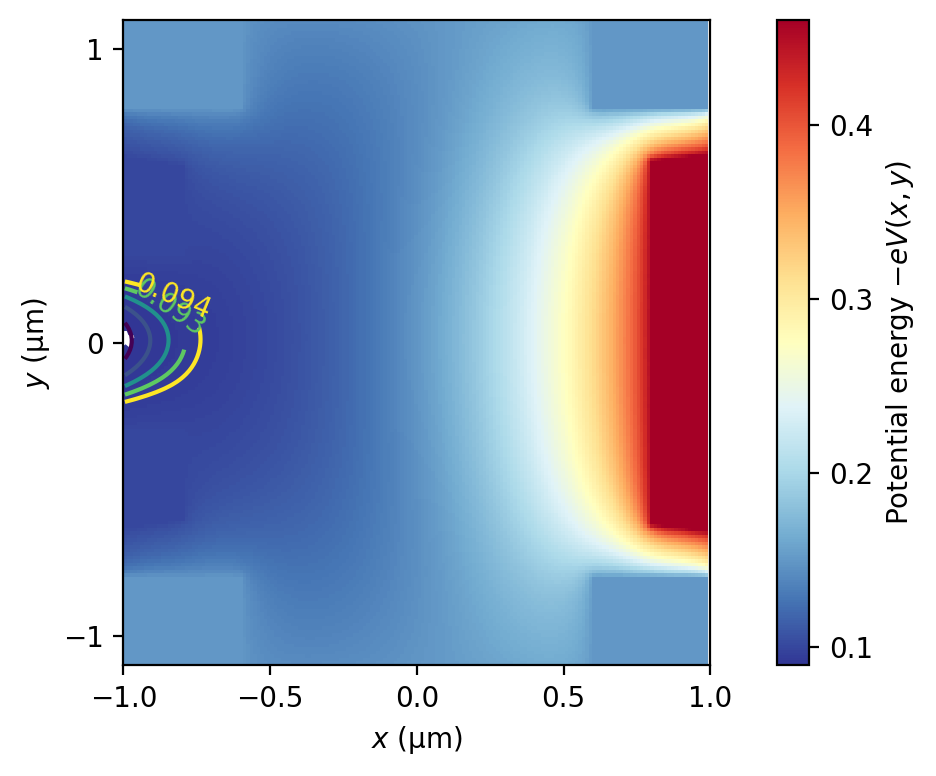

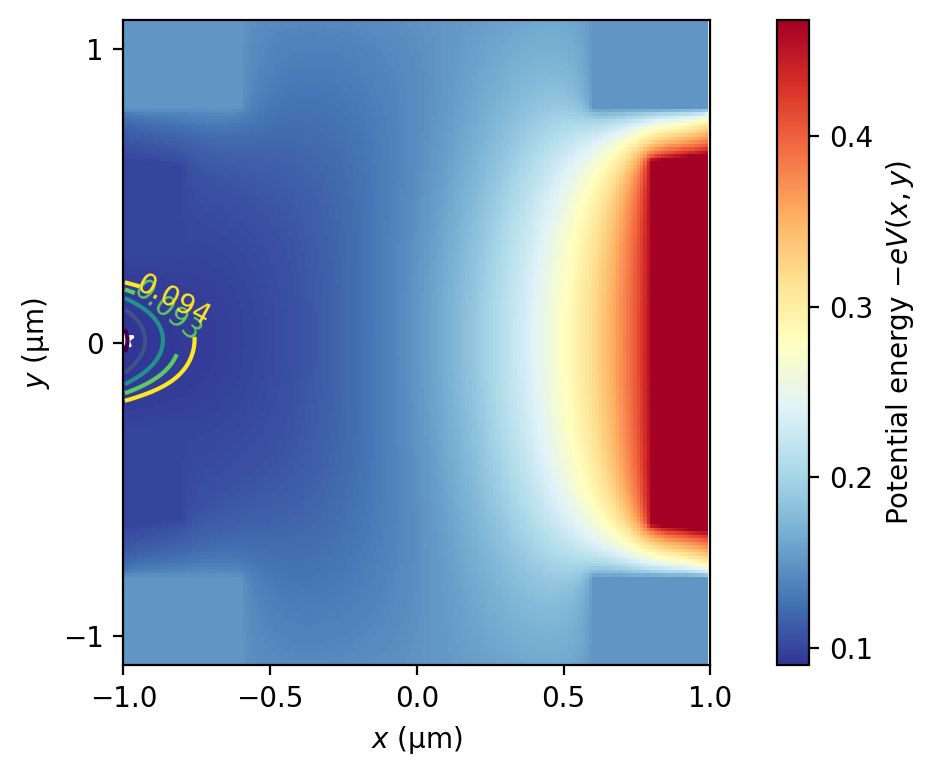

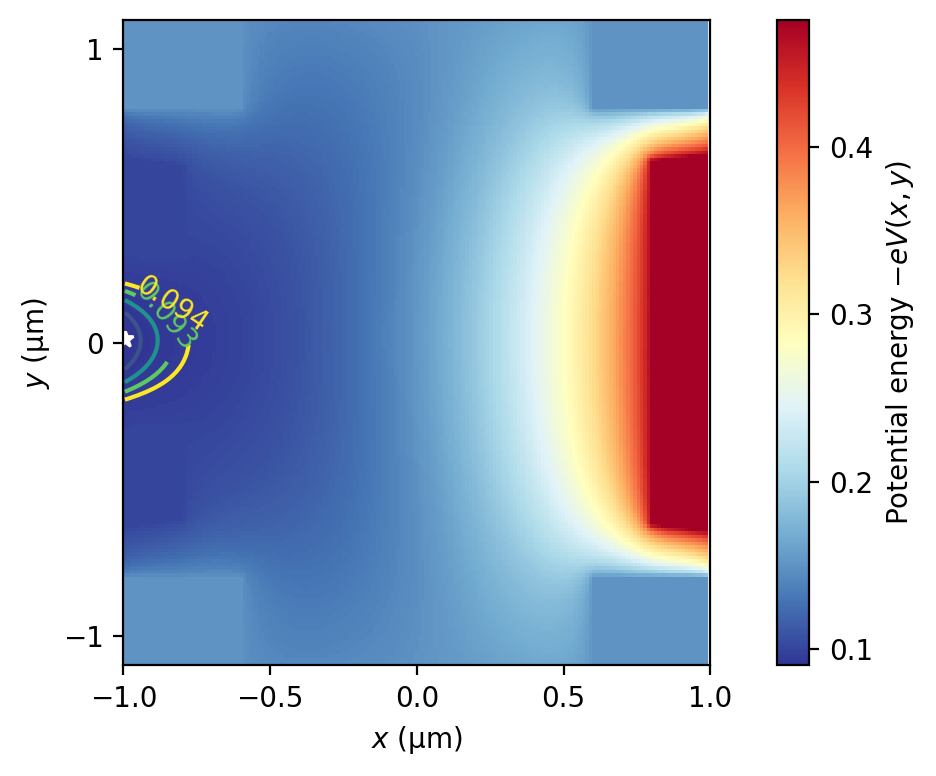

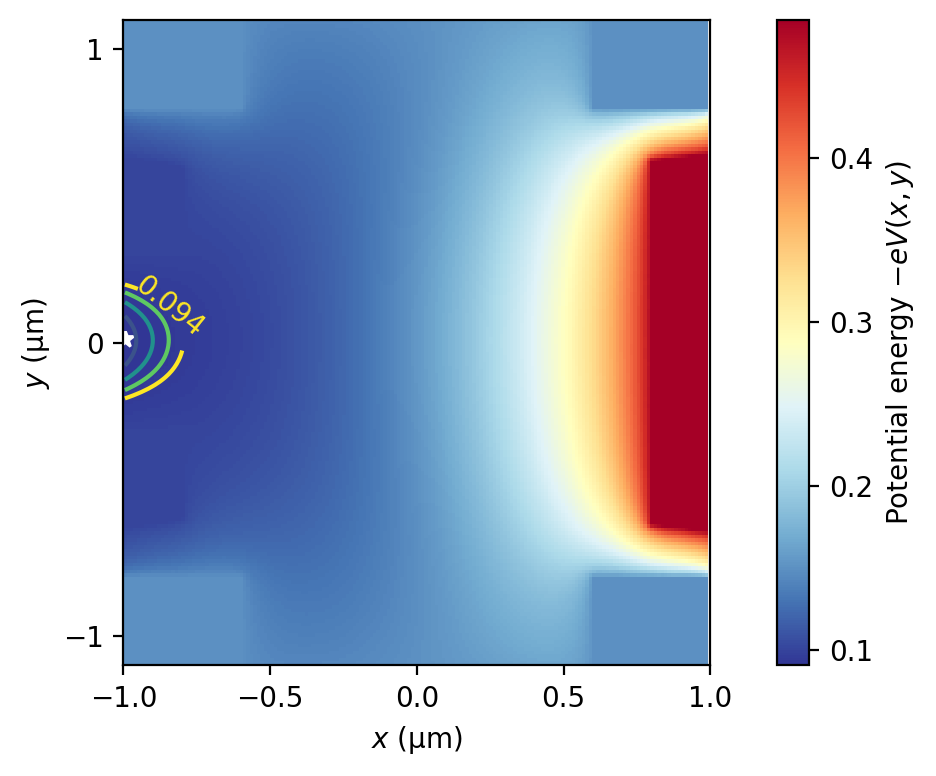

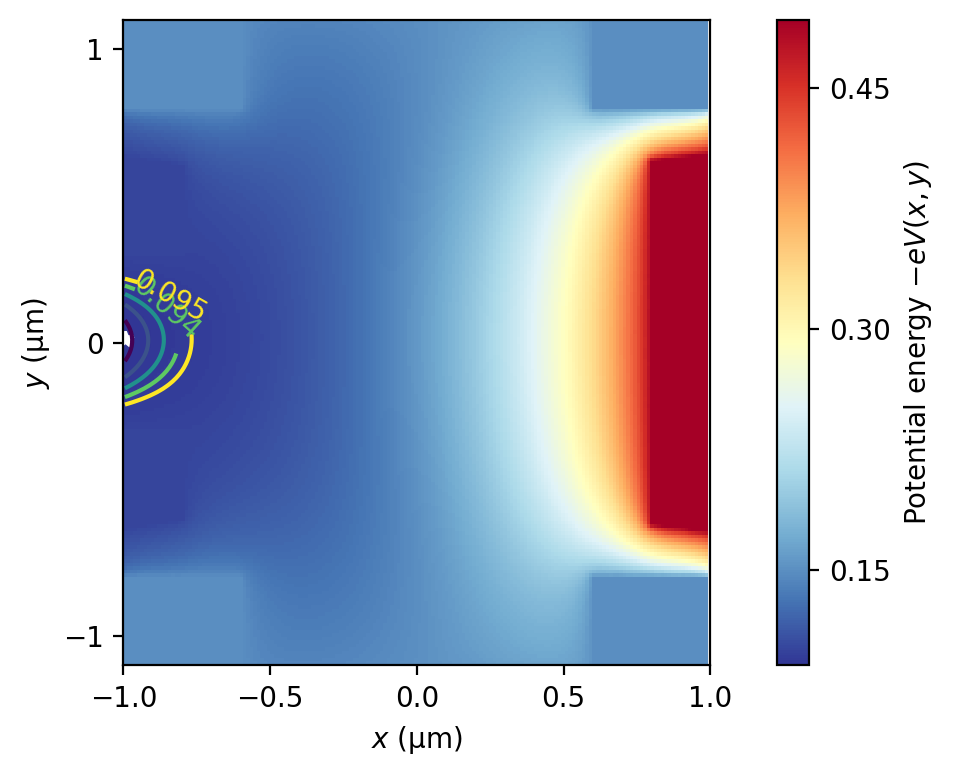

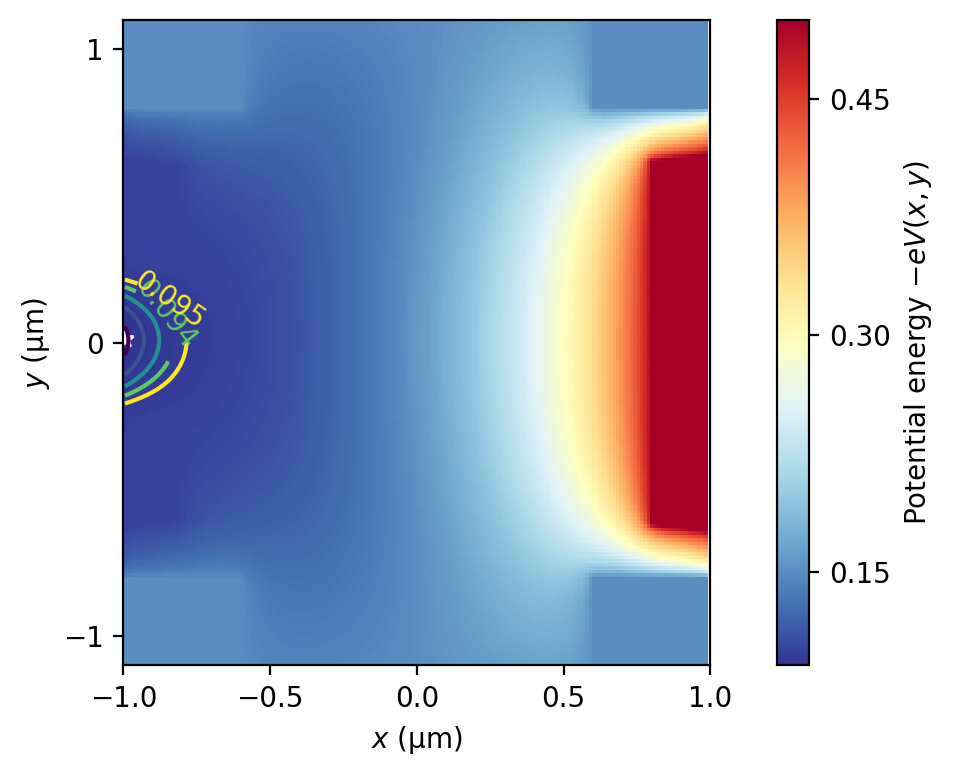

In [6]:
voltages = {'trench':   0.05,
            'gnd':      0, 
            'barrier':  -0.10,
            'resU':     -0.15,
            'resD':     -0.15,
            'unload':   -0.10}

unload_voltages = np.linspace(-0.1, -0.5, 51)

N_init = 2
energies = np.zeros(len(unload_voltages))
num_electrons = np.zeros(len(unload_voltages))

efreqs = np.zeros((len(unload_voltages), 2 * N_init + 1))

for k, unload in enumerate(unload_voltages):
    voltages['unload'] = unload
    
    f = FullModel(trap.dot, voltages)

    f.set_rf_interpolator(rf_electrode_labels=['resU', 'resD'])

    f.remove_unbound_electrons = False
    
    if k == 0: 
        electron_initial_positions = None
    else: 
        electron_initial_positions = res['x']
        
    res = f.get_trap_electron_positions(n_electrons=N_init, electron_initial_positions=electron_initial_positions, verbose=False, suppress_warnings=False)
    
    final_x, final_y = r2xy(res['x'])

    num_electrons[k] = f.count_electrons_in_dot(res['x'])
    
    qa = QuantumAnalysis(trap.dot, voltages)
    qa.plot_potential_energy(coor=[0, 0], dxdy=(2, 2.2))
    plt.plot(final_x*1e6, final_y*1e6, 'ok', mfc='mediumseagreen', mew=0.5, ms=10, path_effects=[pe.SimplePatchShadow(), pe.Normal()])
    # plt.plot(init_trap_x*1e6, init_trap_y*1e6, 'or', ms=3)

    energies[k] = res['fun']
    
    K, M = f.setup_eom(res['x'])
    evals, evecs = f.solve_eom(K, M)
    eigenfrequencies = np.sqrt(evals) / (2 * np.pi)
    
    efreqs[k, :] = eigenfrequencies

In [7]:
np.amax(res['jac'])

18670.251347470436

Text(0, 0.5, 'Cost function')

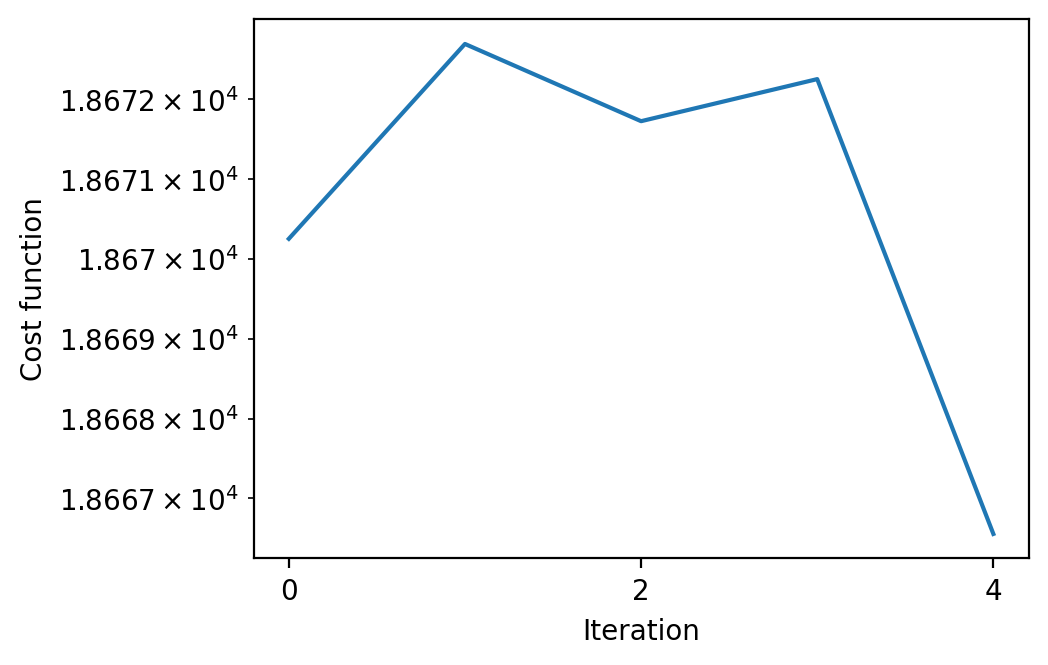

In [8]:
fig = plt.figure(figsize=(5.,3.5))
plt.plot(f.CM.curr_grad_norm)
# plt.plot(cf_w_grad)
plt.yscale('log')
plt.locator_params(axis='x', nbins=4)
plt.xlabel("Iteration")
plt.ylabel("Cost function")
# plt.xlim(-0.5, iter_w_grad) #CM.call_counter)

Text(0, 0.5, 'Number of electrons')

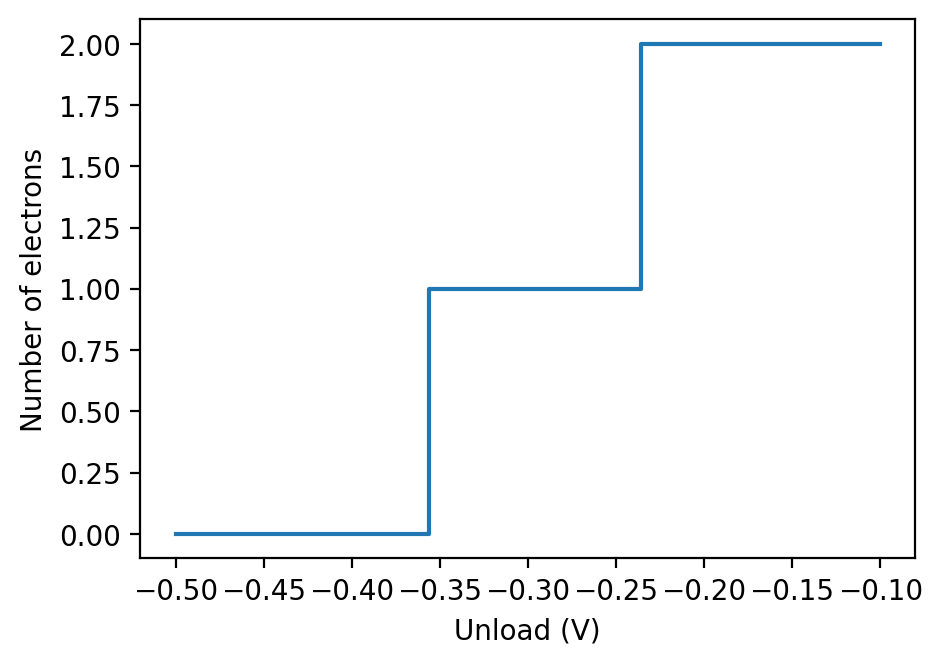

In [9]:
fig = plt.figure(figsize=(5.,3.5))
plt.step(unload_voltages, num_electrons)
plt.xlabel("Unload (V)")
plt.ylabel("Number of electrons")

# Solve equations of motion

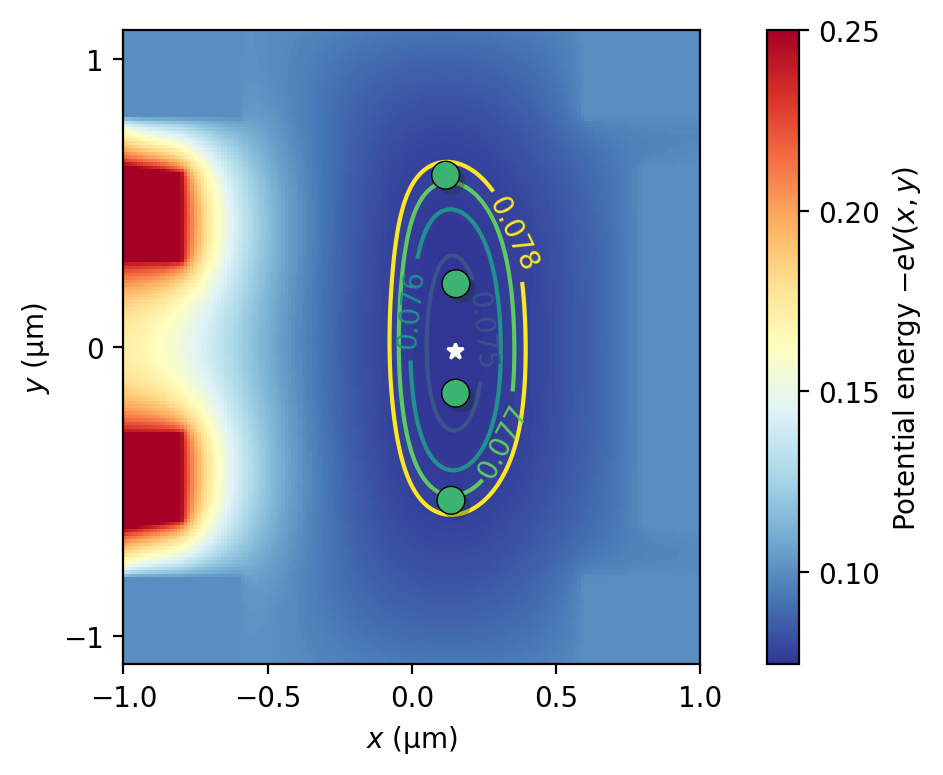

In [10]:
voltages = {'trench':   0.05,
            'gnd':      0, 
            'barrier':  -0.25,
            'resU':     -0.10,
            'resD':     -0.10,
            'unload':   -0.10}

N = 4

f = FullModel(trap.dot, voltages)
f.remove_unbound_electrons = False

initial_condition = f.generate_initial_condition(N)
init_x, init_y = r2xy(initial_condition)
    
res = f.get_trap_electron_positions(n_electrons=N, electron_initial_positions=None, verbose=False)

final_x, final_y = r2xy(res['x'])

qa = QuantumAnalysis(trap.dot, voltages)
qa.plot_potential_energy(coor=[0, 0], dxdy=(2, 2.2))
plt.plot(final_x*1e6, final_y*1e6, 'ok', mfc='mediumseagreen', mew=0.5, ms=10, path_effects=[pe.SimplePatchShadow(), pe.Normal()])
# plt.plot(init_x*1e6, init_y*1e6, 'or', ms=3)

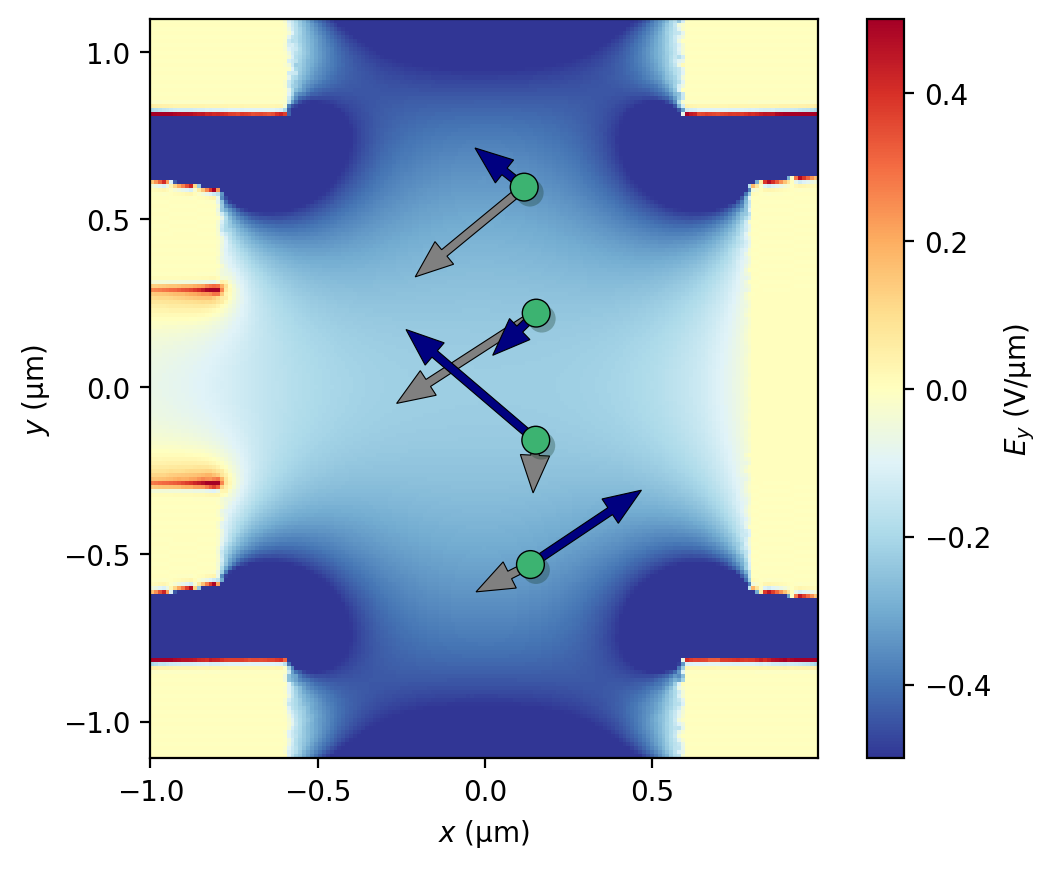

In [30]:
f.set_rf_interpolator(rf_electrode_labels=['resU', 'resD'])

plot_efield = True

if plot_efield: 
    X, Y = np.meshgrid(trap.dot['xlist'] * 1e-6, trap.dot['ylist'] * 1e-6) 
    plt.figure()
    plt.pcolormesh(X * 1e6, Y * 1e6, f.Ey(X, Y) / 1e6, cmap=plt.cm.RdYlBu_r, vmin=-.5, vmax=.5)
    plt.plot(final_x*1e6, final_y*1e6, 'ok', mfc='mediumseagreen', mew=0.5, ms=10, path_effects=[pe.SimplePatchShadow(), pe.Normal()])
    cbar = plt.colorbar()

    cbar.ax.set_ylabel(fr"$E_y$ (V/{chr(956)}m)")
    plt.locator_params(axis='both', nbins=5)
    plt.gca().set_aspect('equal')
    plt.xlabel(rf"$x$ ({chr(956)}m)")
    plt.ylabel(rf"$y$ ({chr(956)}m)")  
else:
    qa = QuantumAnalysis(trap.dot, voltages)
    qa.plot_potential_energy(coor=[0, 0], dxdy=(2, 2.2))
    plt.plot(final_x*1e6, final_y*1e6, 'ok', mfc='mediumseagreen', mew=0.5, ms=10, path_effects=[pe.SimplePatchShadow(), pe.Normal()])

K, M = f.setup_eom(res['x'])
evals, evecs = f.solve_eom(K, M)
eigenfrequencies = np.sqrt(evals) / (2 * np.pi)
cavity_participation = evecs[0, :]

sorted_order = np.argsort(np.abs(cavity_participation))[::-1]
evecs = evecs[:, sorted_order]
eigenfrequencies = eigenfrequencies[sorted_order]

def plot_eigenvector(electron_positions, eigenvector, length=0.5, color='k'):
    e_x, e_y = r2xy(electron_positions)

    evec_norm = eigenvector[1:] / np.linalg.norm(eigenvector[1:])
    dxs, dys = r2xy(evec_norm * length)

    for e_idx in range(N):
        width=0.025
        plt.arrow(e_x[e_idx] * 1e6, e_y[e_idx] * 1e6, dx=dxs[e_idx], dy=dys[e_idx], width=width, head_length=1.5*3 *width, head_width=3.5*width, 
                  edgecolor='k', lw=0.4, facecolor=color)
        
    plt.gca().set_aspect('equal')
    
plot_eigenvector(res['x'], evecs[1], color='gray')
plot_eigenvector(res['x'], evecs[5], color='navy')


In [24]:
cavity_participation

array([ 2.24199613e+04,  1.25920474e+01,  4.45671460e-02, -7.78187976e-01,
        6.08501136e-01,  8.93855116e-01,  1.96706999e-01, -6.16770057e-01,
        2.17316583e-01])

In [25]:
sorted_order

array([0, 1, 5, 3, 7, 4, 8, 6, 2])

In [26]:
eigenfrequencies

array([3.99999537e+09, 1.12866075e+10, 2.12626977e+10, 1.90244431e+10,
       2.36916089e+10, 2.07189247e+10, 2.43692151e+10, 2.30844676e+10,
       1.70232012e+10])

# Sweep Trapguard voltage

Final L-inf norm of gradient = 1.54 eV/m
Please check your initial condition, are all electrons confined in the simulation area?
Final L-inf norm of gradient = 1.42 eV/m
Please check your initial condition, are all electrons confined in the simulation area?
Final L-inf norm of gradient = 1.41 eV/m
Please check your initial condition, are all electrons confined in the simulation area?
Final L-inf norm of gradient = 1.42 eV/m
Please check your initial condition, are all electrons confined in the simulation area?
Final L-inf norm of gradient = 1.42 eV/m
Please check your initial condition, are all electrons confined in the simulation area?
Final L-inf norm of gradient = 1.47 eV/m
Please check your initial condition, are all electrons confined in the simulation area?
Final L-inf norm of gradient = 1.51 eV/m
Please check your initial condition, are all electrons confined in the simulation area?
Final L-inf norm of gradient = 1.50 eV/m
Please check your initial condition, are all electrons c

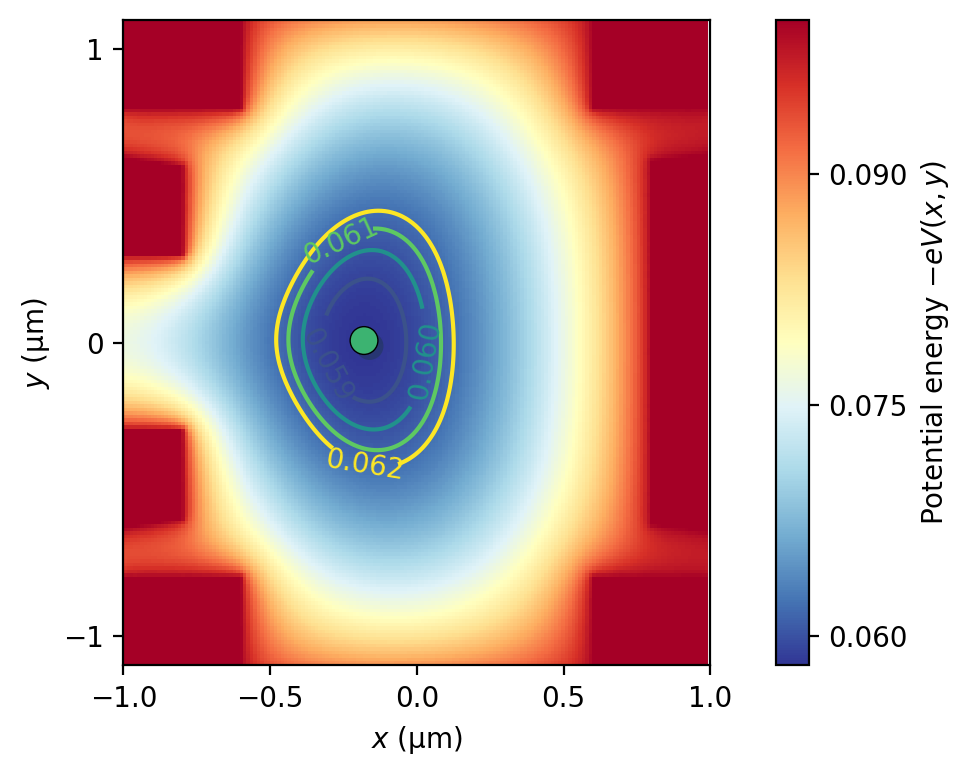

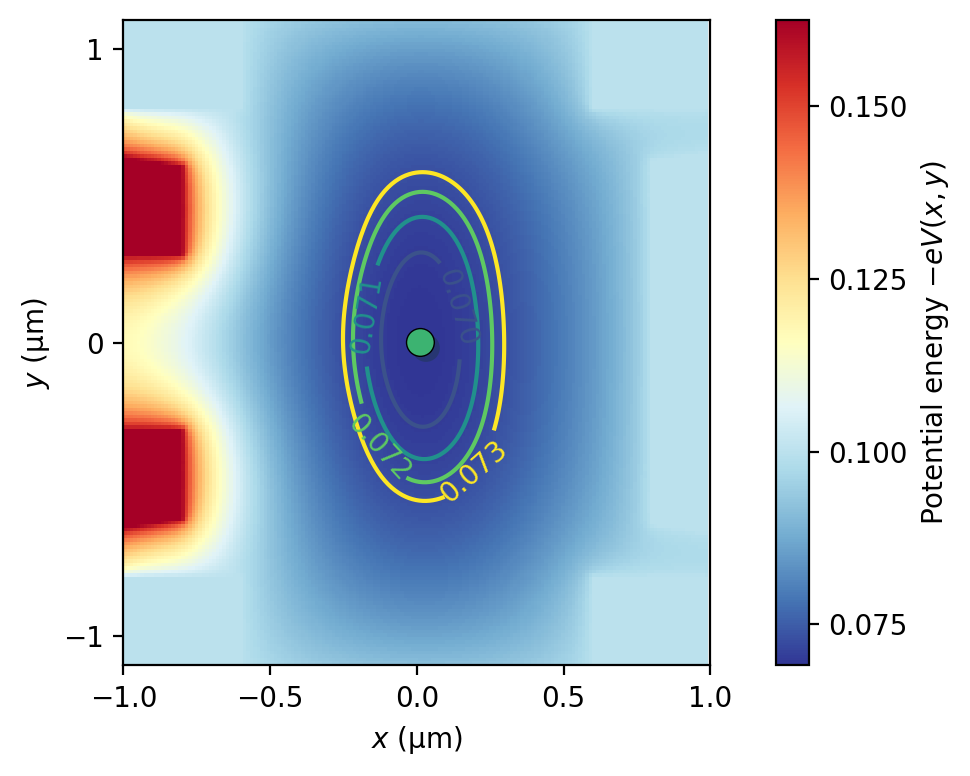

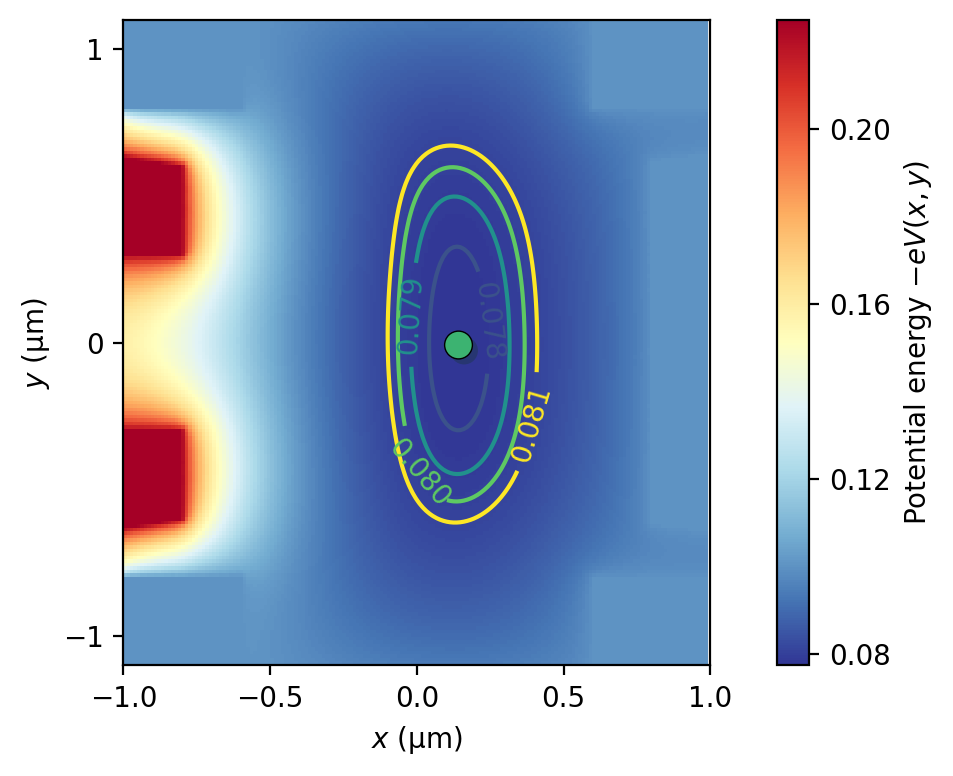

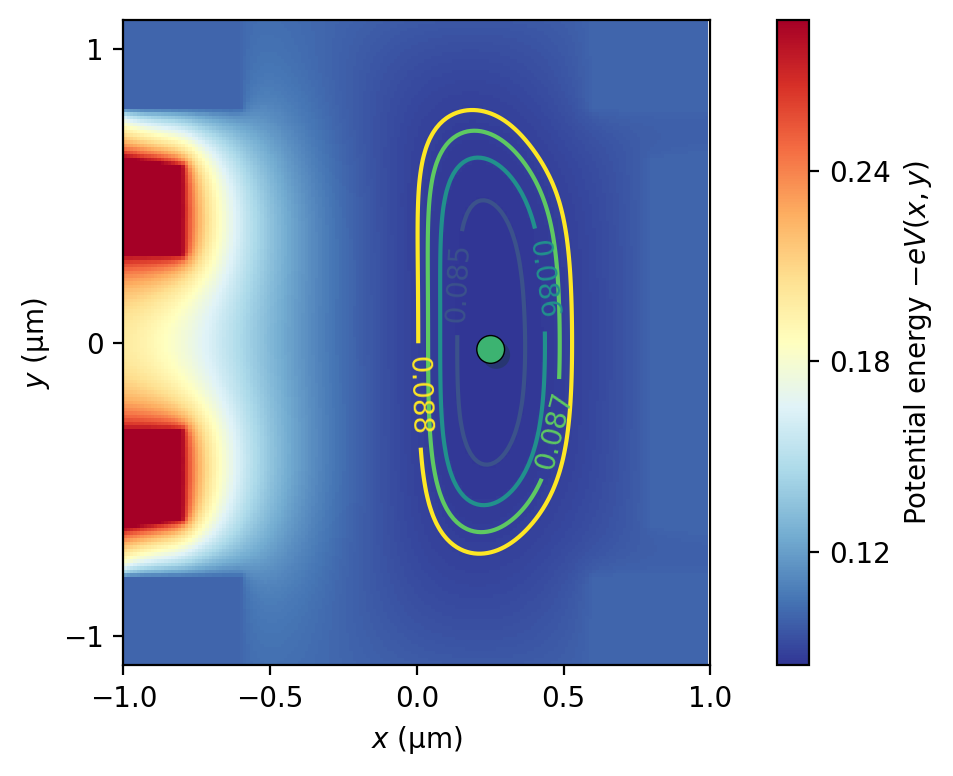

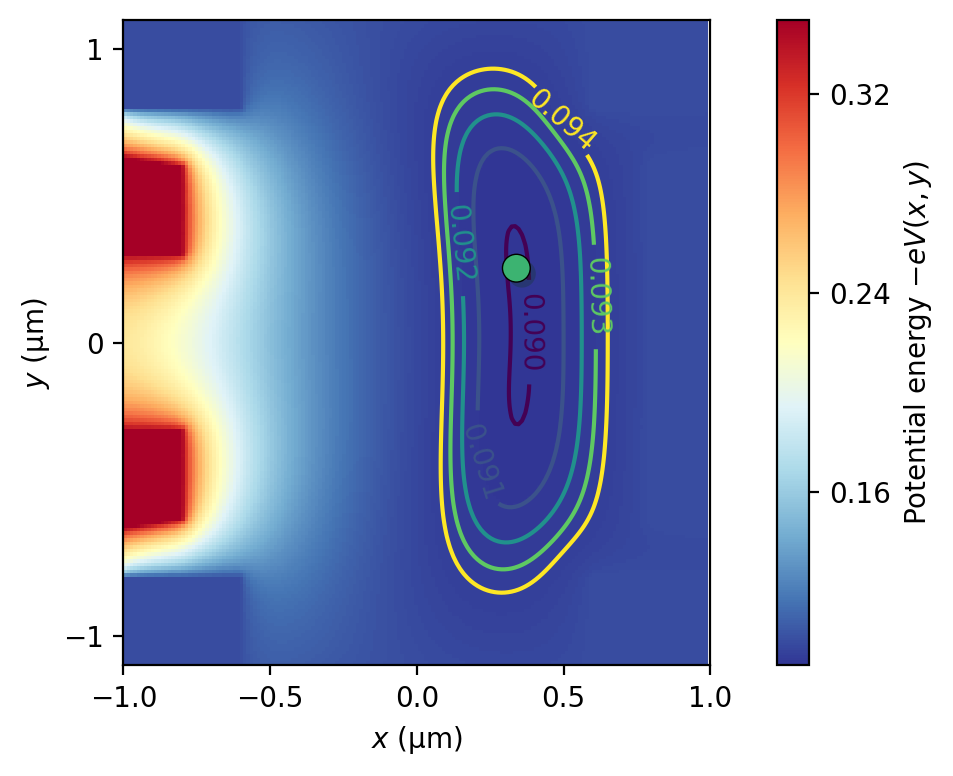

In [53]:
voltages = {'trench':   0.025,
            'gnd':      0, 
            'barrier':  -0.10,
            'resU':     -0.10,
            'resD':     -0.10,
            'unload':   -0.10}

tg_voltages = np.linspace(-0.1, -0.35, 401)
# tg_voltages = np.linspace(-0.26, -0.30, 401)

N_init = 1
energies = np.zeros(len(tg_voltages))
num_electrons = np.zeros(len(tg_voltages))

efreqs = np.zeros((len(tg_voltages), 2 * N_init + 1))

for k, trapguard in enumerate(tg_voltages):
    voltages['barrier'] = trapguard
    
    f = FullModel(trap.dot, voltages)

    f.set_rf_interpolator(rf_electrode_labels=['resU', 'resD'])

    f.remove_unbound_electrons = False
    
    if k == 0: 
        electron_initial_positions = None
    else: 
        electron_initial_positions = res['x']
        
    res = f.get_trap_electron_positions(n_electrons=N_init, electron_initial_positions=electron_initial_positions, verbose=False)
    
    final_x, final_y = r2xy(res['x'])

    num_electrons[k] = f.count_electrons_in_dot(res['x'])
    
    if not k%100:
        qa = QuantumAnalysis(trap.dot, voltages)
        qa.plot_potential_energy(coor=[0, 0], dxdy=(2, 2.2))
        plt.plot(final_x*1e6, final_y*1e6, 'ok', mfc='mediumseagreen', mew=0.5, ms=10, path_effects=[pe.SimplePatchShadow(), pe.Normal()])
        # plt.plot(init_trap_x*1e6, init_trap_y*1e6, 'or', ms=3)

    energies[k] = res['fun']
    
    K, M = f.setup_eom(res['x'])
    evals, evecs = f.solve_eom(K, M)
    cavity_participation = evecs[0, :]
    sorted_order = np.argsort(np.abs(cavity_participation))[::-1]
    evecs = evecs[:, sorted_order]
    
    eigenfrequencies = np.sqrt(evals[sorted_order]) / (2 * np.pi)
    
    efreqs[k, :] = eigenfrequencies

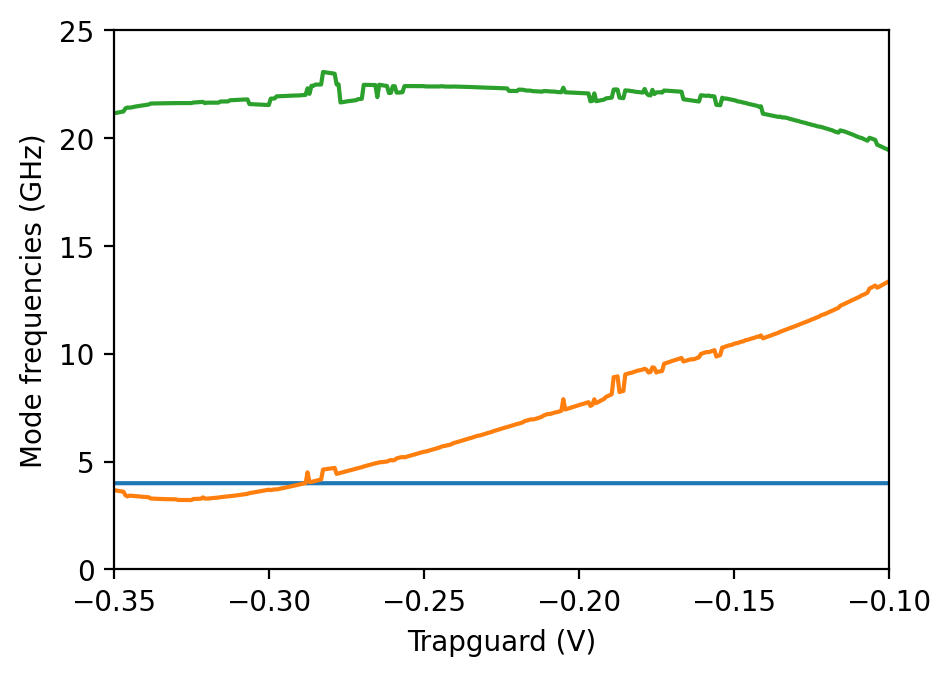

In [54]:
plt.figure(figsize=(5,3.5))
plt.plot(tg_voltages, efreqs/1e9)
plt.xlabel("Trapguard (V)")
plt.ylabel("Mode frequencies (GHz)")
plt.ylim(0, 25)
plt.xlim(np.min(tg_voltages), np.max(tg_voltages))
plt.locator_params(axis='both', nbins=5)

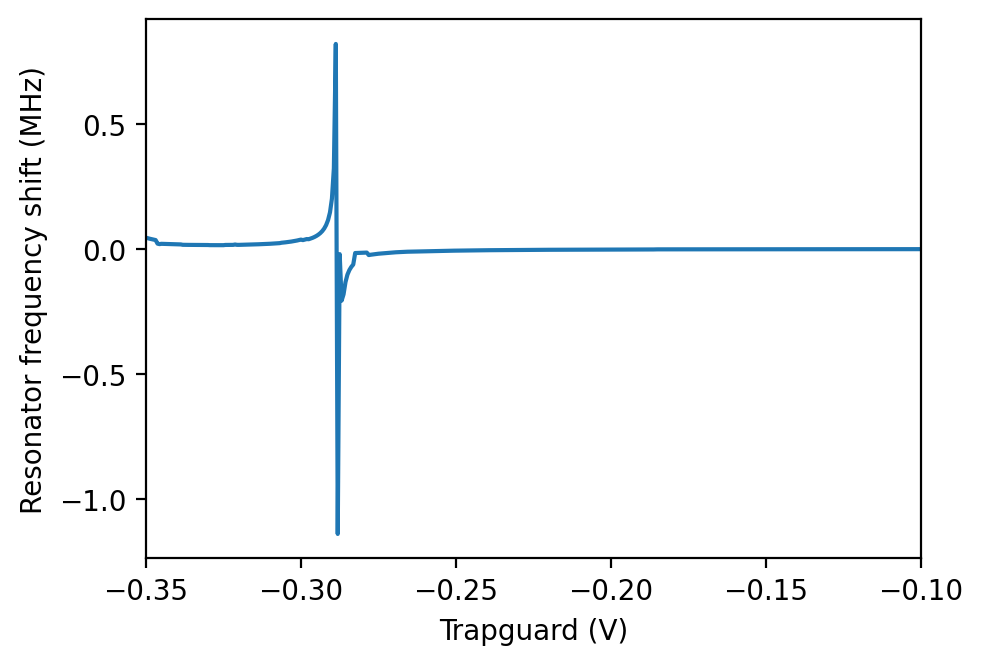

In [55]:
plt.figure(figsize=(5,3.5))
plt.plot(tg_voltages, (efreqs[:, 0] - f.f0)/1e6)
plt.xlabel("Trapguard (V)")
plt.ylabel("Resonator frequency shift (MHz)")
plt.xlim(np.min(tg_voltages), np.max(tg_voltages))
plt.locator_params(axis='both', nbins=5)

# center = -0.288
# span = 0.005
# plt.xlim(center-span/2, center+span/2)

# Counting electrons in the dot

## During the probe sweep

In [92]:
voltages = {'trench':   0.050,
            'gnd':      0, 
            'barrier':  -0.10,
            'resU':     -0.10,
            'resD':     -0.10,
            'unload':   -0.10}

trapguard_voltages = np.linspace(0, -0.35, 51)
trap_voltages = np.linspace(0, 0.10, 11)

num_electrons = np.zeros(len(trap_voltages) * len(trapguard_voltages))

N_max = 15
k = 0

N_init = N_max

for Vtrap, Vtrapguard in tqdm(itertools.product(trap_voltages, trapguard_voltages)):
    voltages['barrier'] = Vtrapguard
    voltages['trench'] = Vtrap
    
    f = FullModel(trap.dot, voltages)

    f.set_rf_interpolator(rf_electrode_labels=['resU', 'resD'])

    f.remove_unbound_electrons = False
        
    not_converged = True
    while not_converged:
        res = f.get_trap_electron_positions(n_electrons=N_init, electron_initial_positions=None, verbose=False, suppress_warnings=True)

        not_converged = (res['status'] > 0)
        final_x, final_y = r2xy(res['x'])

        num_electrons[k] = f.count_electrons_in_dot(res['x'])
        
        if N_init > 1:
            N_init -= 1
        else:
            # There are no more electrons left to run a minimization
            num_electrons[k] = 0
            not_converged = False

    N_init = N_max
    k += 1

0it [00:00, ?it/s]

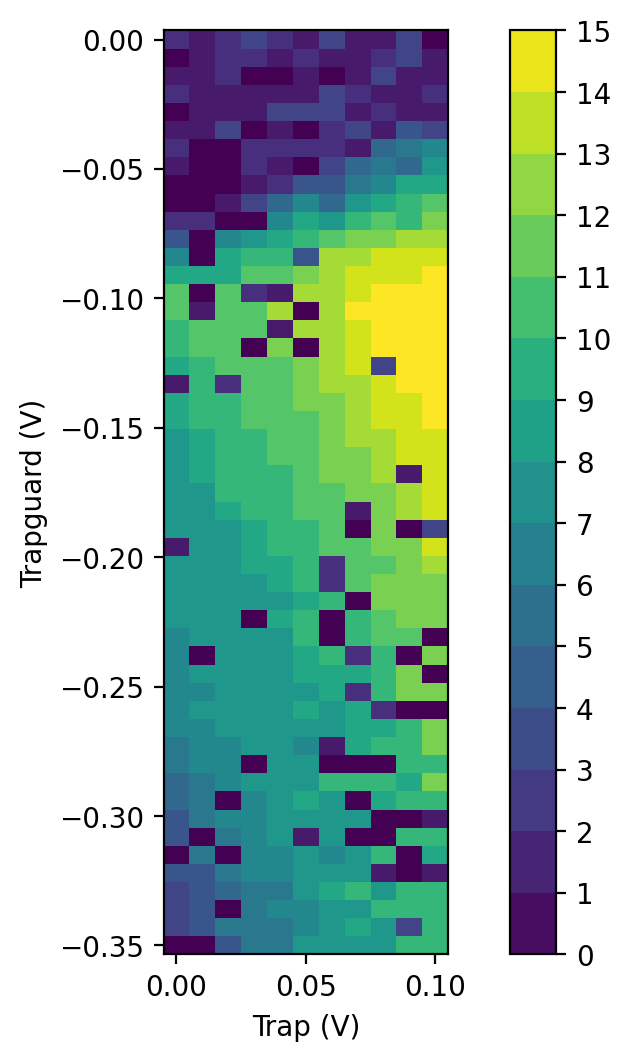

In [93]:
num_electrons = np.reshape(num_electrons, (len(trap_voltages), -1))

# extract all colors from the cmap
cmap = plt.cm.RdYlBu_r
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.arange(0, N_max+0.1, 1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 6))
pcm = plt.pcolormesh(trap_voltages, trapguard_voltages, num_electrons.T)
plt.xlabel("Trap (V)")
plt.ylabel("Trapguard (V)")
plt.gca().set_aspect('equal')

plt.colorbar(pcm, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

## During the unloading

In [98]:
voltages = {'trench':   0.050,
            'gnd':      0, 
            'barrier':  -0.10,
            'resU':     -0.10,
            'resD':     -0.10,
            'unload':   -0.10}

unload_voltages = np.linspace(0, -0.50, 51)
trapguard_voltages = np.linspace(0, -0.2, 21)

num_electrons = np.zeros(len(unload_voltages) * len(trapguard_voltages))

N_max = 15
k = 0

N_init = N_max

for Vunload, Vtrapguard in tqdm(itertools.product(unload_voltages, trapguard_voltages)):
    voltages['barrier'] = Vtrapguard
    voltages['unload'] = Vunload
    
    f = FullModel(trap.dot, voltages)

    f.set_rf_interpolator(rf_electrode_labels=['resU', 'resD'])

    f.remove_unbound_electrons = False
        
    not_converged = True
    while not_converged:
        res = f.get_trap_electron_positions(n_electrons=N_init, electron_initial_positions=None, verbose=False, suppress_warnings=True)

        not_converged = (res['status'] > 0)
        final_x, final_y = r2xy(res['x'])

        num_electrons[k] = f.count_electrons_in_dot(res['x'])
        
        if N_init > 1:
            N_init -= 1
        else:
            # There are no more electrons left to run a minimization
            num_electrons[k] = 0
            not_converged = False

    N_init = N_max
    k += 1

0it [00:00, ?it/s]

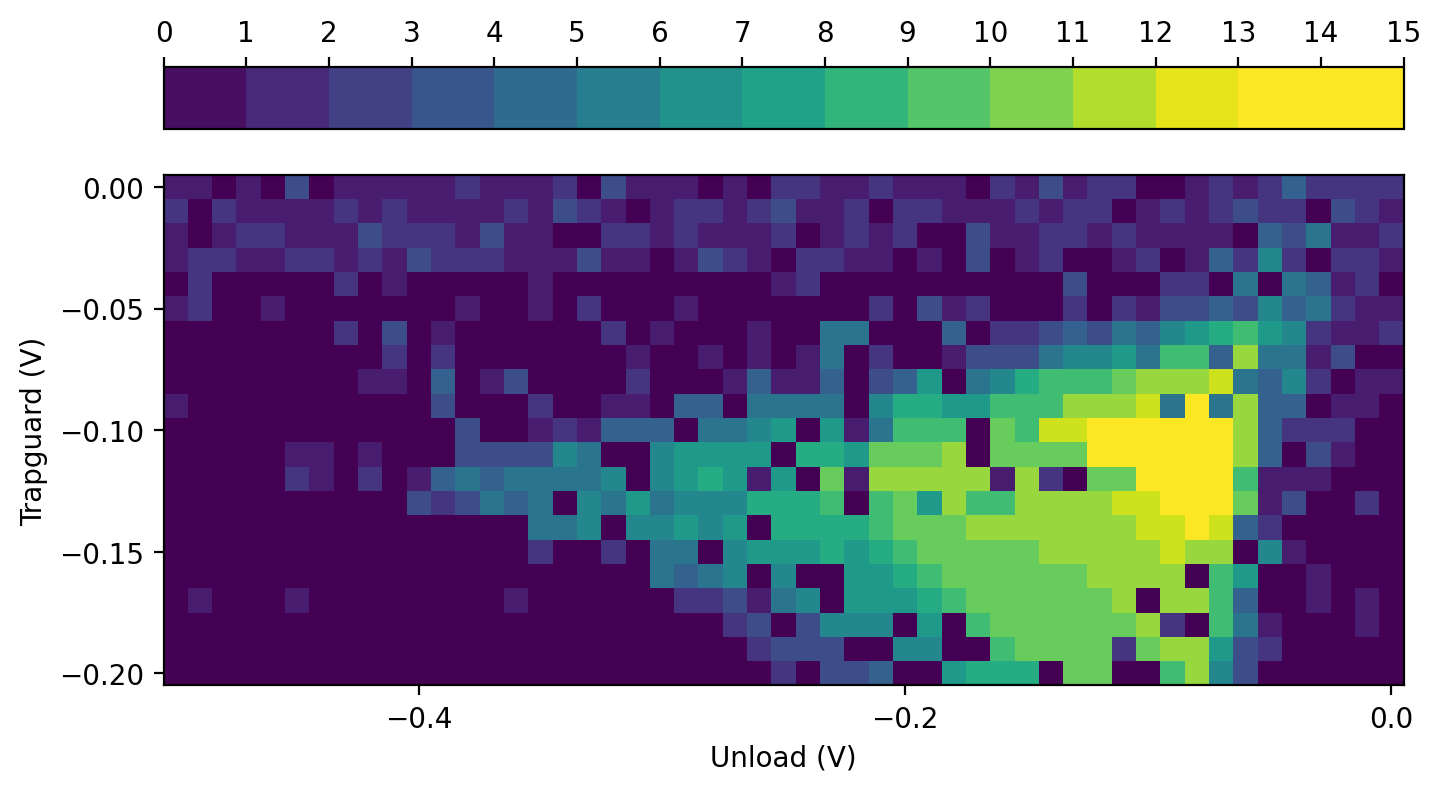

In [105]:
num_electrons = np.reshape(num_electrons, (len(unload_voltages), -1))

# extract all colors from the cmap
cmap = plt.cm.RdYlBu_r
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.arange(0, N_max+0.1, 1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 6))
pcm = plt.pcolormesh(unload_voltages, trapguard_voltages, num_electrons.T)
plt.xlabel("Unload (V)")
plt.ylabel("Trapguard (V)")

plt.colorbar(pcm, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i', orientation='horizontal', location='top')

plt.gca().set_aspect('equal')
plt.locator_params(axis='both', nbins=5)

# Animation

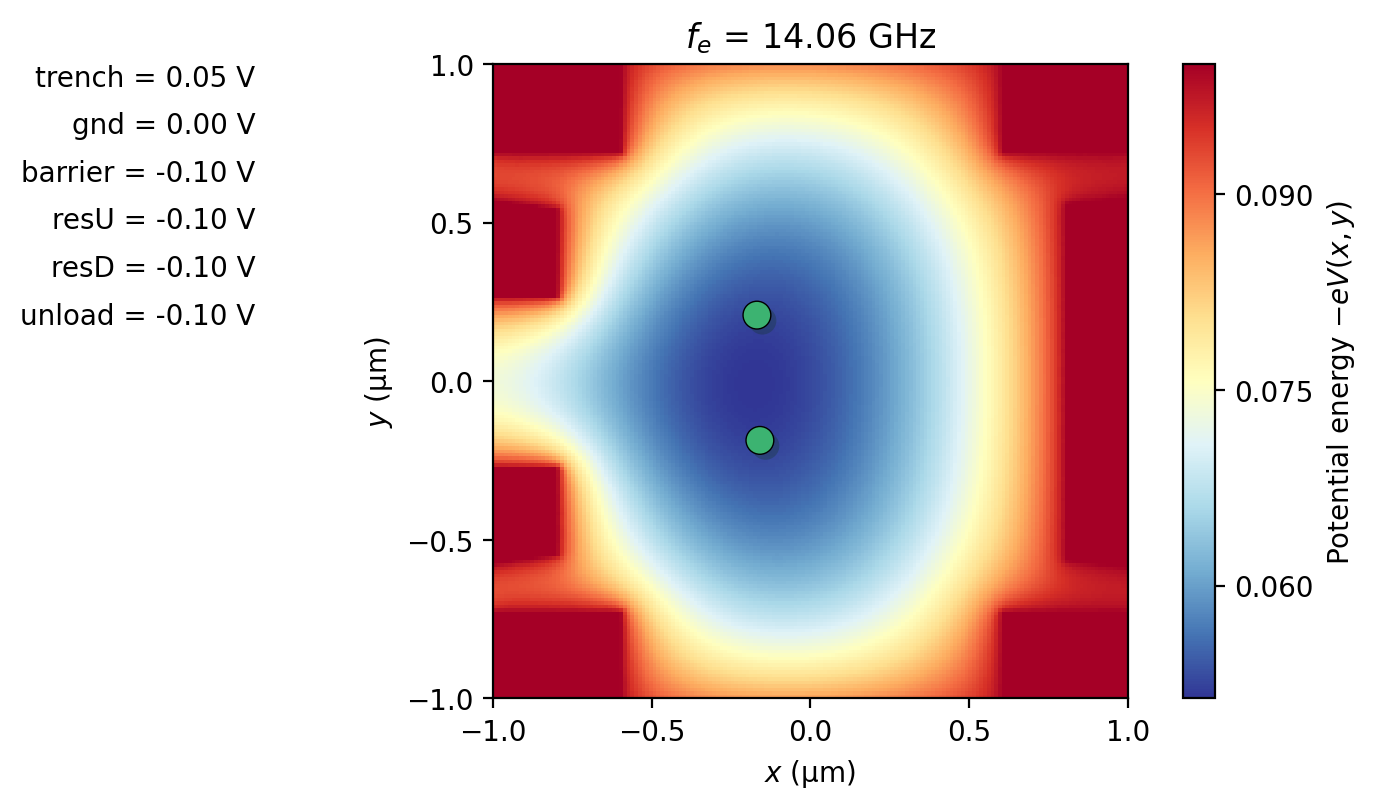

In [109]:
voltages = {'trench':   0.05,
            'gnd':      0.00, 
            'barrier':  -0.10,
            'resU':     -0.10,
            'resD':     -0.10,
            'unload':   -0.10}

tg_voltages = np.linspace(-0.1, -0.35, 101)
coor = [0, 0]
dxdy = [2, 2]

N_init = 2

import matplotlib.animation as animation
import matplotlib

f = FullModel(trap.dot, voltages)
f.set_rf_interpolator(rf_electrode_labels=['resU', 'resD'])
f.remove_unbound_electrons = False
electron_initial_positions = None 
res = f.get_trap_electron_positions(n_electrons=N_init, electron_initial_positions=electron_initial_positions, verbose=False)
final_x, final_y = r2xy(res['x'])

potential = make_potential(f.potential_dict, f.voltage_dict)
zdata = -potential.T

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
img_data = ax.imshow(zdata, cmap=plt.cm.RdYlBu_r, extent=[coor[0] - dxdy[0]/2, coor[0] + dxdy[0]/2, coor[1] - dxdy[1]/2, coor[1] + dxdy[1]/2])
pts_data = ax.plot(final_x*1e6, final_y*1e6, 'ok', mfc='mediumseagreen', mew=0.5, ms=10, path_effects=[pe.SimplePatchShadow(), pe.Normal()])

cbar = plt.colorbar(img_data)
tick_locator = matplotlib.ticker.MaxNLocator(nbins=4)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.set_ylabel(r"Potential energy $-eV(x,y)$")

xidx, yidx = np.unravel_index(zdata.argmin(), zdata.shape)
# plt.plot(f.potential_dict['xlist'][yidx], f.potential_dict['ylist'][xidx], '*', color='white')

ax.set_xlim(coor[0] - dxdy[0]/2, coor[0] + dxdy[0]/2)
ax.set_ylim(coor[1] - dxdy[1]/2, coor[1] + dxdy[1]/2)

text_boxes = list()
for k, electrode in enumerate(voltages.keys()):
    text_boxes.append(ax.text(-1.75, 1.0 - k * 0.15, f"{electrode} = {voltages[electrode]:.2f} V", ha='right', va='top'))

ax.set_aspect('equal')

# contours = [np.round(np.min(zdata), 3) +k*1e-3 for k in range(5)]
# CS = plt.contour(f.potential_dict['xlist'], f.potential_dict['ylist'], zdata, levels=contours)
# ax.clabel(CS, CS.levels, inline=True, fontsize=10)

plt.xlabel("$x$"+f" ({chr(956)}m)")
plt.ylabel("$y$"+f" ({chr(956)}m)")
plt.locator_params(axis='both', nbins=4)

fig.tight_layout()

def update(frame):
    
    voltages['barrier'] = tg_voltages[frame]
    
    f = FullModel(trap.dot, voltages)
    f.set_rf_interpolator(rf_electrode_labels=['resU', 'resD'])
    f.remove_unbound_electrons = False
    electron_initial_positions = None 
    res = f.get_trap_electron_positions(n_electrons=N_init, electron_initial_positions=electron_initial_positions, 
                                        verbose=False, suppress_warnings=True)
    final_x, final_y = r2xy(res['x'])
    
    potential = make_potential(f.potential_dict, f.voltage_dict)
    zdata = -potential.T

    # print(final_x, final_y)
    img_data.set_data(zdata)

    pts_data[0].set_xdata(final_x * 1e6)
    pts_data[0].set_ydata(final_y * 1e6)
    
    K, M = f.setup_eom(res['x'])
    evals, evecs = f.solve_eom(K, M)
    eigenfrequencies = np.sqrt(evals) / (2 * np.pi)
    
    ax.set_title(f"$f_e$ = {eigenfrequencies[1]/1e9:.2f} GHz")
    
    for k, electrode in enumerate(voltages.keys()):
        text_boxes[k].set_text(f"{electrode} = {voltages[electrode]:.2f} V")
    
    # efreqs[k, :] = eigenfrequencies
    
    return (img_data, pts_data)
    
# interval is in milliseconds
ani = animation.FuncAnimation(fig=fig, func=update, frames=len(tg_voltages), 
                              interval=33, repeat=True)
# plt.show()

In [110]:
# converting to an html5 video 
video = ani.to_html5_video() 
  
# embedding for the video 
html = display.HTML(video) 
  
# draw the animation 
display.display(html)


In [111]:
writer = animation.PillowWriter(fps=15, bitrate=1800)

ani.save(r'/Users/gerwinkoolstra/Desktop/Unloading.gif', writer=writer)